In [1]:
from netCDF4 import Dataset, MFDataset                     # For reading data
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt                 # For plotting
import numpy.ma as ma
import xray

from mpas_xarray import preprocess_mpas, remove_repeated_time_index
# Place figures within document
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0) # Large figures
axis_font = {'fontname':'Arial', 'size':'24'}    
title_font = {'fontname':'Arial', 'size':'20', 'color':'black', 'weight':'normal'}
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set the file names
rootPath = '/lustre/scratch2/turquoise/lvanroekel/init_ziso/ocean/ziso/2.5km/default/forward/'
#rootPath = '/net/scratch1/pwolfram/ZISO_10km/'
meshFile = rootPath + 'init.nc'
initFile = rootPath + 'init.nc'
forcingFile = rootPath + 'forcing.nc'
EPFile = rootPath + 'analysis_members/eliassenPalm.0008-04-01.nc'
outputFile = rootPath + 'output/KPP_test.0008-04-01_00.00.00.nc'

meshData = xray.open_dataset(meshFile);
initData = xray.open_dataset(initFile);
forcingData = xray.open_dataset(forcingFile);
EPDataT = xray.open_mfdataset(EPFile,preprocess=preprocess_mpas);
outputDataT = xray.open_mfdataset(outputFile,preprocess=preprocess_mpas);

#EPData = EPDataT.mean(dim="Time")
EPData = EPDataT.isel(Time=0)
outputData = outputDataT.mean(dim="Time")


In [32]:
EPDataT.sigmaEA.shape

(1, 337528, 250)

In [87]:
threshold = 0.01
noBuoy = np.where(EPData.buoyancyMaskEA.values < threshold)

In [95]:
len(noBuoy[0])

38837816

In [10]:
EPFT.max()

8.8817841970012523e-16

In [3]:
vn = Dataset('/lustre/scratch2/turquoise/lvanroekel/init_ziso/ocean/ziso/2.5km/default/forward/analysis_members/eliassenPalm.0008-04-01.nc')
EPFT = vn.variables['EPFT'][:]

In [4]:
nBinsLongitude = 400
nBinsLatitude = 400

rtd = 180.0/pi

latCell = meshData.latCell.values;
latCellMax = np.amax(latCell)
latCellMin = np.amin(latCell)

lonCell = meshData.lonCell.values;
indVals = np.where(lonCell > np.pi)
lonCell[indVals] -= np.pi*2.0
lonCellMax = 120*np.pi/180. #np.amax(lonCell)
lonCellMin = 50*np.pi/180. #np.amin(lonCell)

lonCellMax = np.amax(lonCell)
lonCellMin = np.amin(lonCell)

binWidthLongitude = (lonCellMax - lonCellMin) / nBinsLongitude
binWidthLatitude =  (latCellMax - latCellMin) / nBinsLatitude

binEdgeLatitude = zeros((nBinsLatitude+1))
for j in range(0,nBinsLatitude+1):
    binEdgeLatitude[j] = latCellMin + j*binWidthLatitude

binCenterLatitude = zeros((nBinsLatitude))
for j in range(0,nBinsLatitude):
    binCenterLatitude[j] = (binEdgeLatitude[j] + binEdgeLatitude[j+1])/2.0
    
binEdgeLongitude = zeros((nBinsLongitude+1))
for i in range(0,nBinsLongitude+1):
    binEdgeLongitude[i] = lonCellMin + i*binWidthLongitude

binCenterLongitude = zeros((nBinsLongitude))
for i in range(0,nBinsLongitude):
    binCenterLongitude[i] = (binEdgeLongitude[i] + binEdgeLongitude[i+1])/2.0

print 'min latCell: ', latCellMin*rtd
print 'max latCell: ', latCellMax*rtd
print 'min lonCell: ', lonCellMin*rtd
print 'max lonCell: ', lonCellMax*rtd

min latCell:  -69.9996107486
max latCell:  -52.0144199613
min lonCell:  -179.998529378
max lonCell:  179.998115864


In [5]:
lonCellMax = 20*np.pi/180.
lonCellMin = -20*np.pi/180.

lonT = meshData.lonCell.values
inds = np.where(lonT > np.pi)[0]
lonT[inds] -= 2.*np.pi

inds = np.where((lonT > lonCellMin) & (lonT < lonCellMax) )[0]

In [7]:
meshData.latCell.max()*180/np.pi

<xarray.DataArray 'latCell' ()>
array(-52.014419961335335)

In [6]:
EPData = EPData.sel(nCells=inds)
outputData = outputData.sel(nCells=inds)
forcingData = forcingData.sel(nCells=inds)
meshData = meshData.sel(nCells=inds)

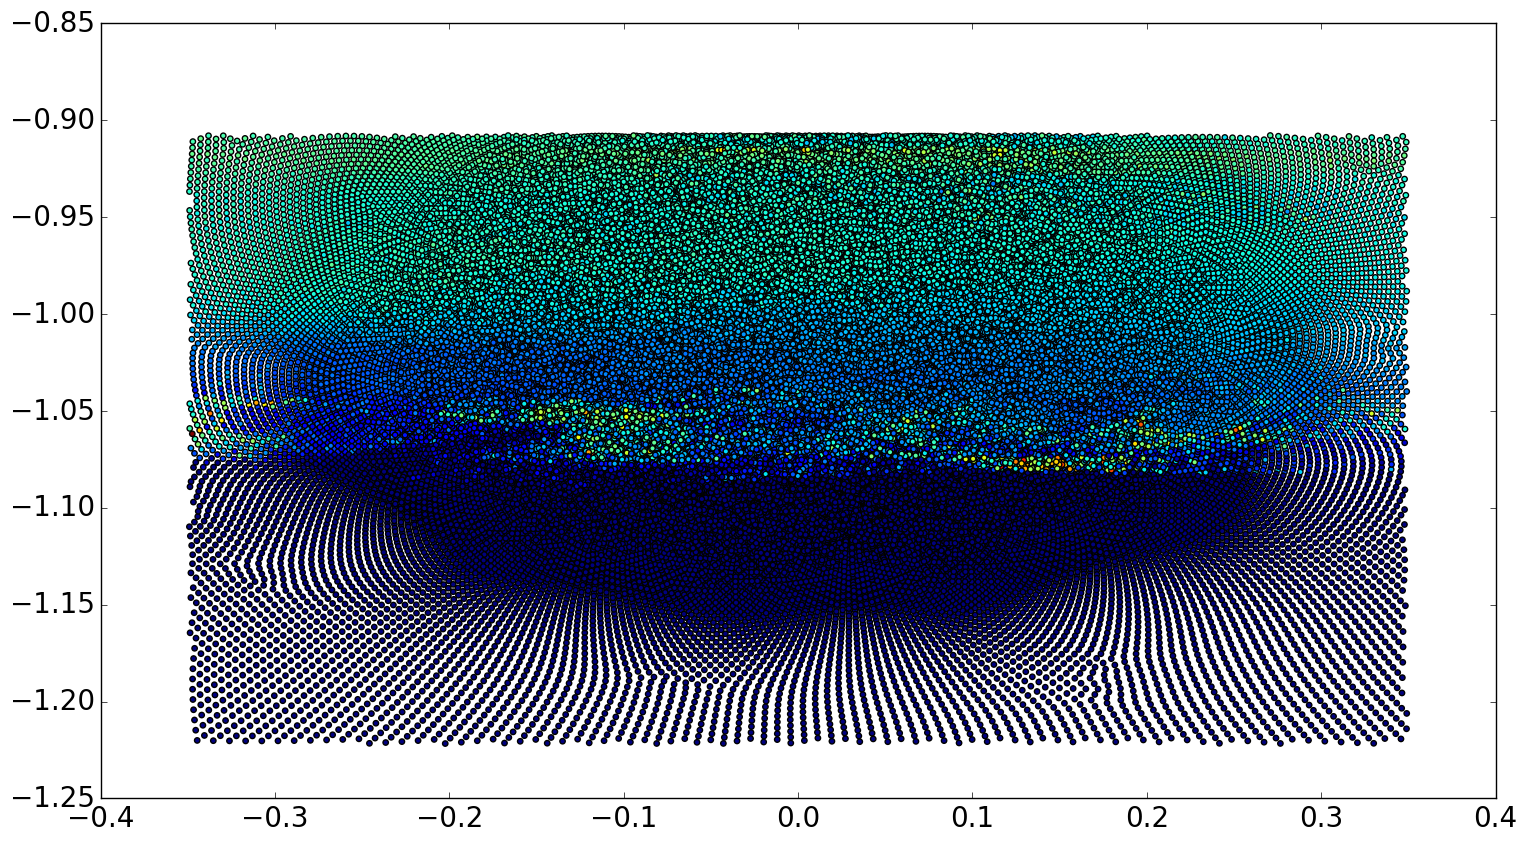

In [7]:
plt.scatter(meshData.lonCell,meshData.latCell,s=15,c=EPData.sigmaEA[:,100])

In [8]:
#Prepare an index dictionary for averaging in zonal direction
binEdgeLat = np.linspace(latCellMin,latCellMax,nBinsLatitude+1)

meshData = meshData.update({'latCell':meshData.latCell})
meshData = meshData.set_coords('latCell')

gbobj = meshData.latCell.groupby_bins('latCell',binEdgeLat,right=True)
binningDict = gbobj.groups

In [9]:
#add an index to match the binning Dictionary for appropriate placement of column average
for key,value in binningDict.iteritems():
    stemp = key[1:-1].replace(',',' ').split()
    latsearch = 0.5*(float(stemp[0]) + float(stemp[1]))
    
    spot = abs(binCenterLatitude - latsearch).argmin()
    
    binningDict[key] = (spot,binningDict[key])

In [10]:
potentialDensityTopRef = EPData.potentialDensityTopRef.values
potentialDensityMidRef = EPData.potentialDensityMidRef.values

In [11]:
def bin_fields2(sortingDict, fieldin, nlats, nlevs):

    fieldout = np.zeros((nlats,nlevs))
    for key,value in sortingDict.iteritems():
        fieldout[sortingDict[key][0],:] = np.nanmean(fieldin[sortingDict[key][1],:],axis=0)
    return fieldout


In [12]:
def bin_fields(nlats,nlevs,latmask,infield):
    outfield = zeros((nlats,nlevs))
    for jBin in range(0,nlats):
        binMask=ma.masked_not_equal(latmask,jBin) - jBin + 1    # this produces a 0/1 mask
        binMask = binMask.astype(int)
        for kLevel in range(0,nlevs):
            rMask = np.multiply(infield[:,kLevel],binMask)
            outfield[jBin,kLevel]=np.sum(rMask)/np.sum(binMask)
            
    return outfield

In [13]:
config_eos_linear_alpha = 0.255
config_eos_linear_Tref = 19.0
config_eos_linear_densityref = 1025.0
config_density0 = 1026.0

temperatureRef = -(potentialDensityMidRef[:]-config_eos_linear_densityref)/config_eos_linear_alpha + config_eos_linear_Tref

In [14]:

nCells = meshData.dims['nCells'];
nVertices = meshData.dims['nVertices'];
nEdges = meshData.dims['nEdges'];
nVertLevels = outputData.dims['nVertLevels'];
nBuoyancyLevels = EPData.dims['nBuoyancyLayers']
#nTime = EPData.dims['Time'];

print 'mesh file: ', meshFile
print 'init file: ', initFile
print 'forcing file: ', forcingFile
print 'output file: ', outputFile
print ' '
print 'nCells: ', nCells
print 'nVertices: ', nVertices
print 'nEdges: ', nEdges
print 'nVertLevels: ', nVertLevels
print 'nBuoyancyLevels: ', nBuoyancyLevels
#print 'nTime: ', nTime

mesh file:  /lustre/scratch2/turquoise/lvanroekel/init_ziso/ocean/ziso/2.5km/default/forward/init.nc
init file:  /lustre/scratch2/turquoise/lvanroekel/init_ziso/ocean/ziso/2.5km/default/forward/init.nc
forcing file:  /lustre/scratch2/turquoise/lvanroekel/init_ziso/ocean/ziso/2.5km/default/forward/forcing.nc
output file:  /lustre/scratch2/turquoise/lvanroekel/init_ziso/ocean/ziso/2.5km/default/forward/output/KPP_test.0008-04-01_00.00.00.nc
 
nCells:  254024
nVertices:  677180
nEdges:  1014708
nVertLevels:  100
nBuoyancyLevels:  250


In [15]:
#get buoyancy levels and thresholding
potentialDensityMidRef = EPData.potentialDensityMidRef.values;

gravity = 9.81
potentialDensityOffset = 1029.0
potentialDen = np.array(potentialDensityMidRef) - potentialDensityOffset

config_density0 = 1026.
buoyancy = -gravity * potentialDen / config_density0

samplingThreshold = 0.05

print ''
print ' sampling threshold in percent: ', samplingThreshold*100
print ''


 sampling threshold in percent:  5.0



In [16]:
nCells = meshData.dims['nCells']

In [17]:
#sort mesh into latitude and longitude masks
maskLongitude = zeros((nCells))-10
maskLongitude = maskLongitude.astype(int)
maskLatitude = zeros((nCells))-10
maskLatitude = maskLatitude.astype(int)

#assign every iCell between lonMin and LonMax to a longitude/latitude bin
for iCell in range(nCells):
    longitude = lonCell[iCell]
    latitude = latCell[iCell]
#    if longitude >= lonCellMin and longitude <= lonCellMax:
    iBin = (longitude-binCenterLongitude[0])/binWidthLongitude
    maskLongitude[iCell]=np.rint(iBin)
    jBin = (latitude-binCenterLatitude[0])/binWidthLatitude
    maskLatitude[iCell]=np.rint(jBin)

print 'min/max longitude bin value: ', np.amin(maskLongitude),np.amax(maskLongitude) 
print 'min/max latitude bin value: ', np.amin(maskLongitude),np.amax(maskLatitude) 

min/max longitude bin value:  0 400
min/max latitude bin value:  0 399


In [18]:
1.47/10/365*60

0.024164383561643833

In [19]:
zv = initData.refZMid.values
temp=outputData.temperature.values
U = outputData.velocityZonal.values
V = outputData.velocityMeridional.values

bintemp = bin_fields2(binningDict, temp, \
                                  nBinsLatitude, nVertLevels)

print 'done with T'

binU = bin_fields2(binningDict, U, \
                                  nBinsLatitude, nVertLevels)

print 'done with U'

binV = bin_fields2(binningDict, V, \
                                  nBinsLatitude, nVertLevels)

print 'done with V'

ind2 = np.where(bintemp < -5)

bintemp[ind2[0],ind2[1]] = NaN
binU[ind2[0],ind2[1]] = NaN
binV[ind2[0],ind2[1]] = NaN

done with T
done with U
done with V


/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


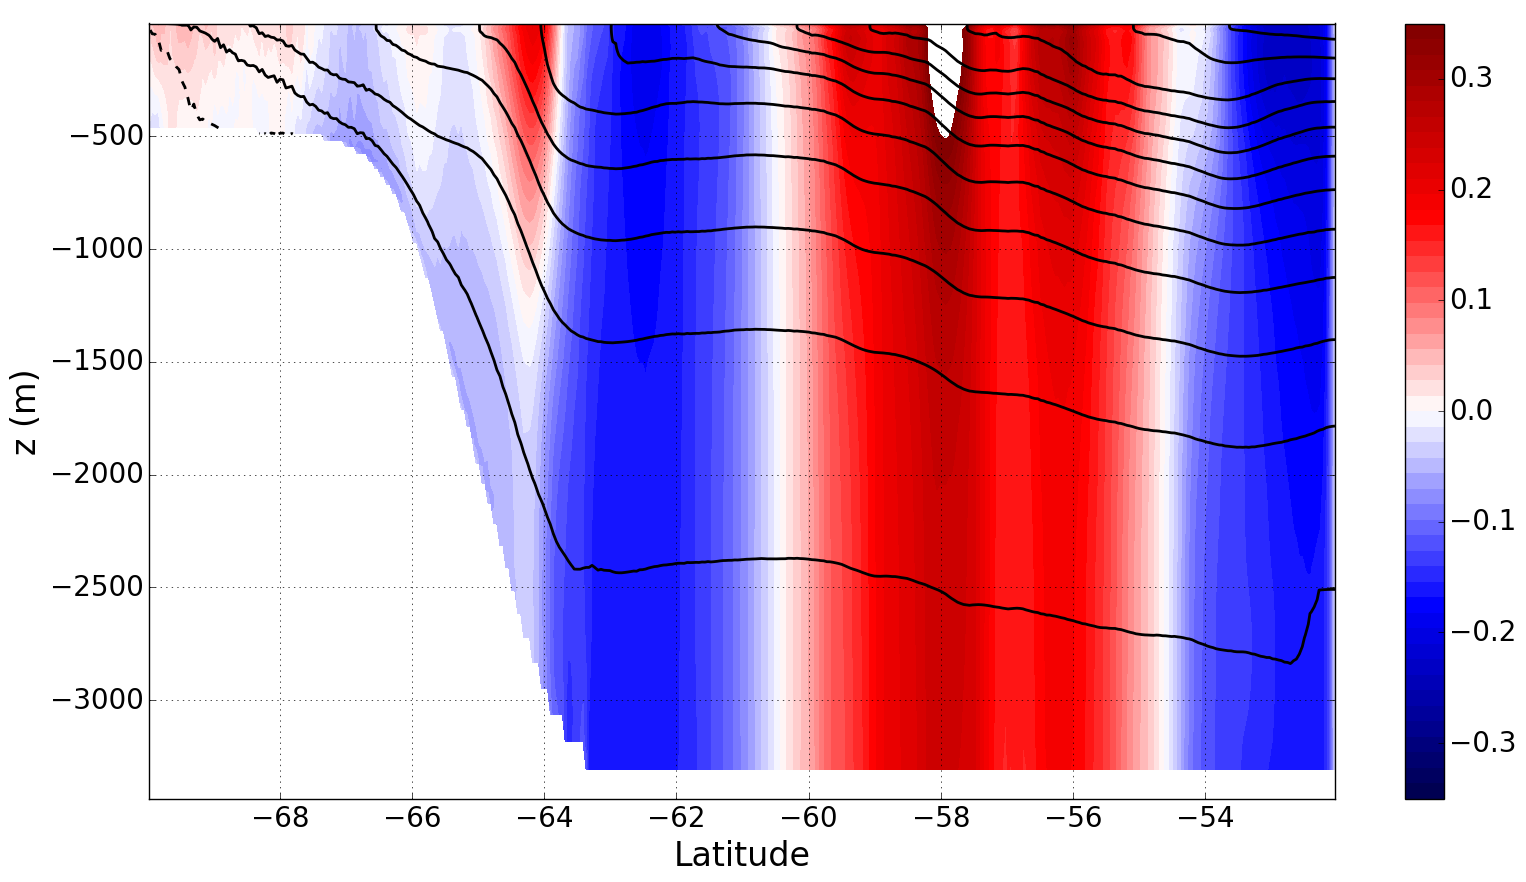

In [20]:
#NEED Nice plotting CODE here For U and T
velocityZonalColors = linspace(-.35, 0.35, 51)
velocityZonalTicks = [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]
temperatureContours = linspace(-1.0, 6.0, 15)

plt.contourf(binCenterLatitude*rtd, zv, binU.T, cmap=plt.cm.seismic, levels=velocityZonalColors);
plt.colorbar(orientation='vertical', fraction=0.1, extend='both', ticks=velocityZonalTicks);
plt.contour(binCenterLatitude*rtd, zv, bintemp.T, Linewidth=20, levels=temperatureContours, colors='k', linewidths=2);
plt.xlabel("Latitude", **axis_font)
plt.ylabel('z (m)', **axis_font)
plt.grid()

In [21]:
#zonally-averaged masking

#read in ensemble-averaged buoyancy mask
buoyancyMaskEA = EPData.buoyancyMaskEA.values;

#buoyancyMaskEA[noBuoy[0],noBuoy[1]] = NaN

#produce a lat/lon version of this mask

binned_buoyancyMaskEA = bin_fields2(binningDict, buoyancyMaskEA, nBinsLatitude, nBuoyancyLevels)

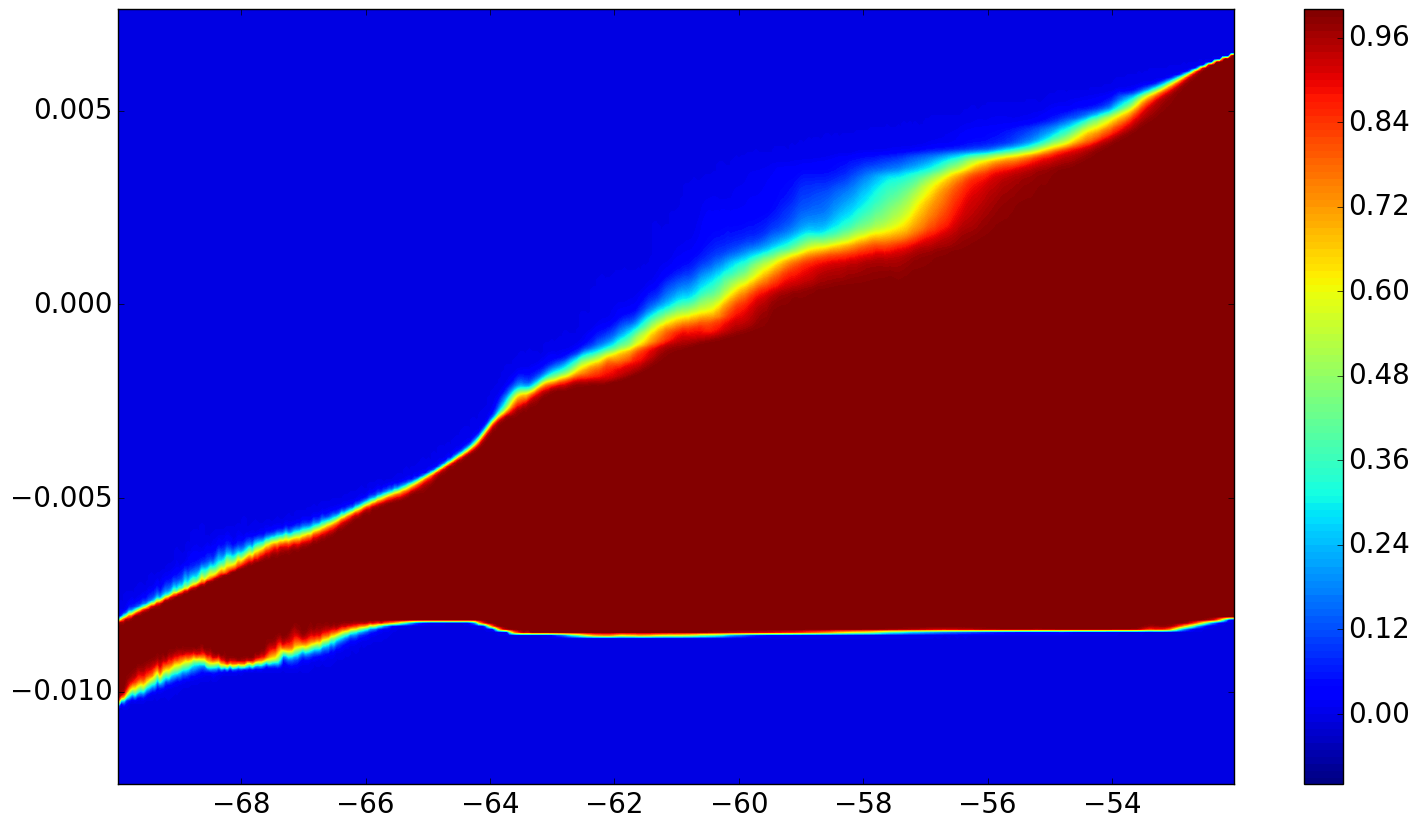

In [22]:
colorLevels=linspace(-0.1,1.00,111)
contourLevels=linspace(0.0,1.0,21)
plt.contourf(binCenterLatitude*rtd,buoyancy,binned_buoyancyMaskEA.T,levels=colorLevels)
plt.colorbar()
#plt.contour(binCenterLatitude*rtd,buoyancy,binned_buoyancyMaskEA.T,levels=contourLevels,colors='gray',linewidth=2)

In [23]:
oceanMask2 = np.ones(buoyancyMaskEA.shape)
threshold = 0.01
indVs = np.where(buoyancyMaskEA < threshold )
oceanMask2[indVs[0],indVs[1]] = NaN


In [24]:
oceanMask = bin_fields2(binningDict, oceanMask2, nBinsLatitude, nBuoyancyLevels)

/usr/projects/climate/lvanroekel/conda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


done with Sigma EA averaging
done with height averaging


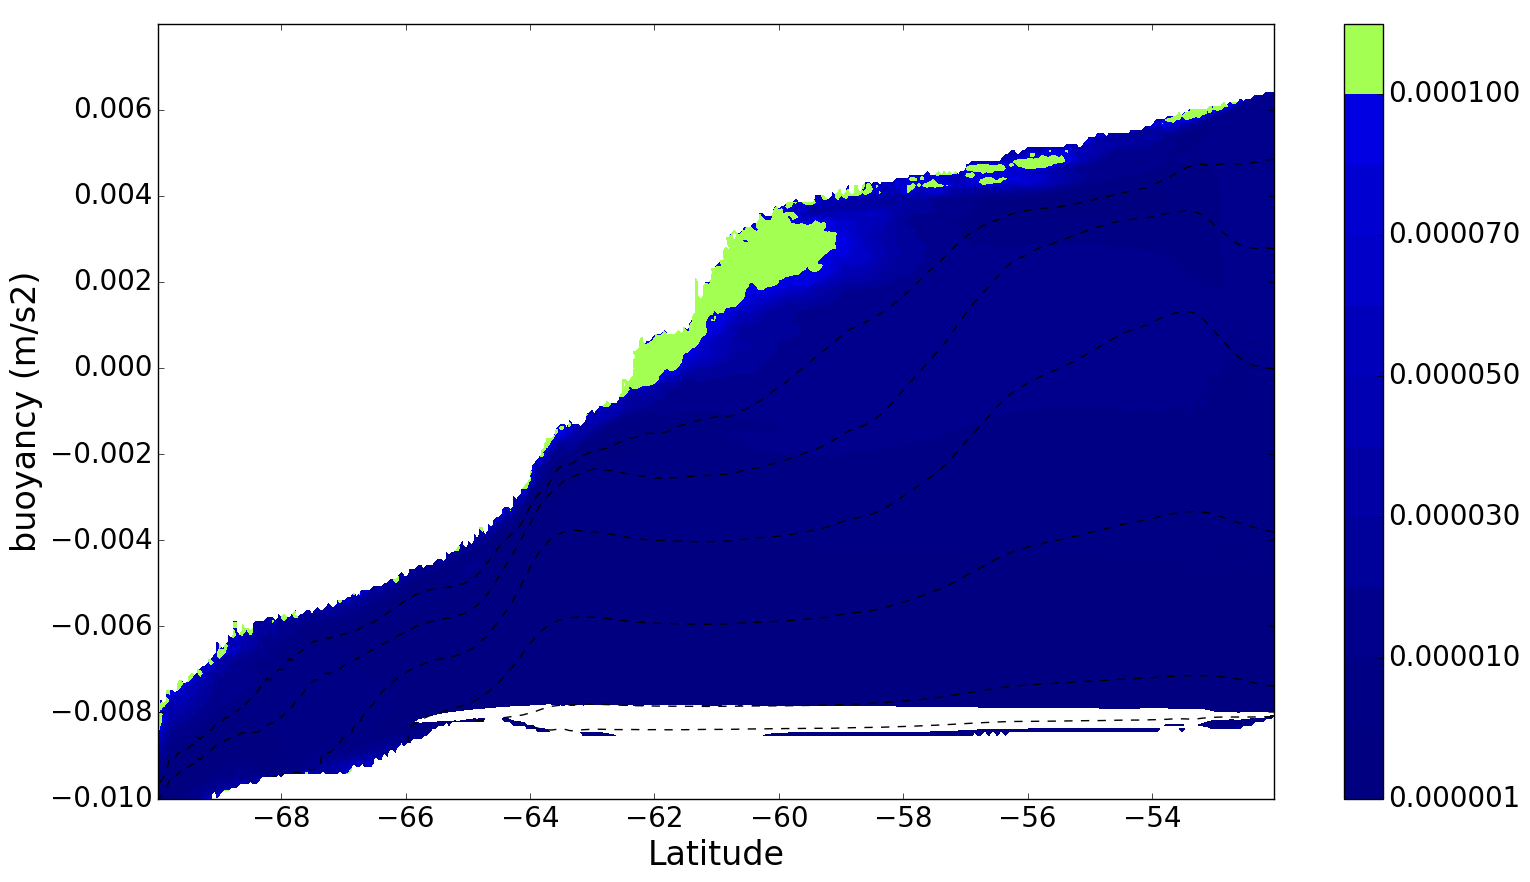

In [25]:
sigmaEA = EPData.sigmaEA.values

N2EA = np.divide(1.0,sigmaEA)

#sigmaEA[noBuoy[0],noBuoy[1]] = NaN
sigmaEA = np.multiply(sigmaEA, oceanMask2)
#N2EA = np.multiply(N2EA, oceanMask2)
binnedN2EA = bin_fields2(binningDict, N2EA, nBinsLatitude, nBuoyancyLevels)
binnedsigmaEA = bin_fields2(binningDict, sigmaEA, nBinsLatitude, nBuoyancyLevels)

print 'done with Sigma EA averaging'

heightMidBuoyCoorEA = EPData.heightMidBuoyCoorEA.values
heightMidBuoyCoorEA = np.multiply(heightMidBuoyCoorEA, oceanMask2)
binnedheightMidBuoyCoorEA = bin_fields2(binningDict, heightMidBuoyCoorEA, nBinsLatitude, nBuoyancyLevels)

print 'done with height averaging'

#contours for sigma
scaling = 1e5
sigmaLevels = linspace(0.0, 5.0, 101)
sigmaLevels = np.multiply(sigmaLevels, scaling)

#contours for N2
N2Levels = [1.0e-6, 5.0e-6, 1.0e-5, 2.0e-5, 3.0e-5, 4.0e-5, 5.0e-5, 6.0e-5, 7.0e-5, 8.0e-5, 1.0e-4, 1.0e-3 ]

#contours for occurrence of buoyancy levels
maskLevels = [0.1, 0.25, 0.5, 0.95]

#contours for height
heightLevels = [-3000, -2000, -1000, -500, -250, -100]


plt.contourf(binCenterLatitude*rtd, buoyancy, (1./binnedsigmaEA).T, levels=N2Levels);
plt.colorbar();
plt.contour(binCenterLatitude*rtd, buoyancy, oceanMask.T, levels=maskLevels, colors='r');
plt.contour(binCenterLatitude*rtd, buoyancy, binnedheightMidBuoyCoorEA.T, levels=heightLevels, colors='k');
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)


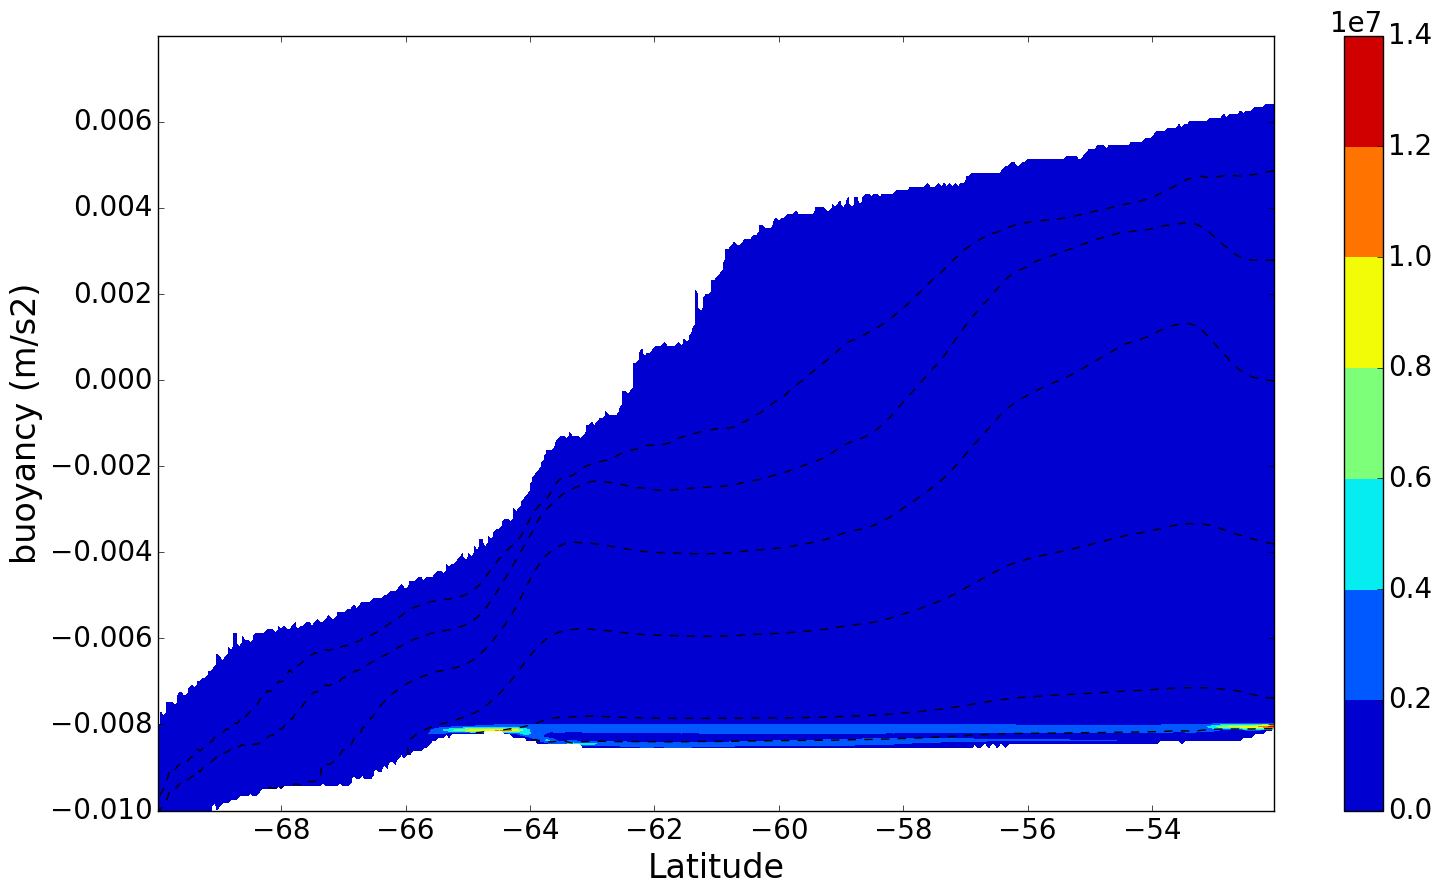

In [26]:
plt.contourf(binCenterLatitude*rtd, buoyancy, (binnedsigmaEA).T);
plt.colorbar();
plt.contour(binCenterLatitude*rtd, buoyancy, oceanMask.T, levels=maskLevels, colors='r');
plt.contour(binCenterLatitude*rtd, buoyancy, binnedheightMidBuoyCoorEA.T, levels=heightLevels, colors='k');
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

In [27]:
#uTWA and vTWA
uTWA = EPData.uTWA.values;
vTWA = EPData.vTWA.values;

binned_uTWA = bin_fields2(binningDict, uTWA, nBinsLatitude, nBuoyancyLevels)
binned_vTWA = bin_fields2(binningDict, vTWA, nBinsLatitude, nBuoyancyLevels)
        
print 'done'

done


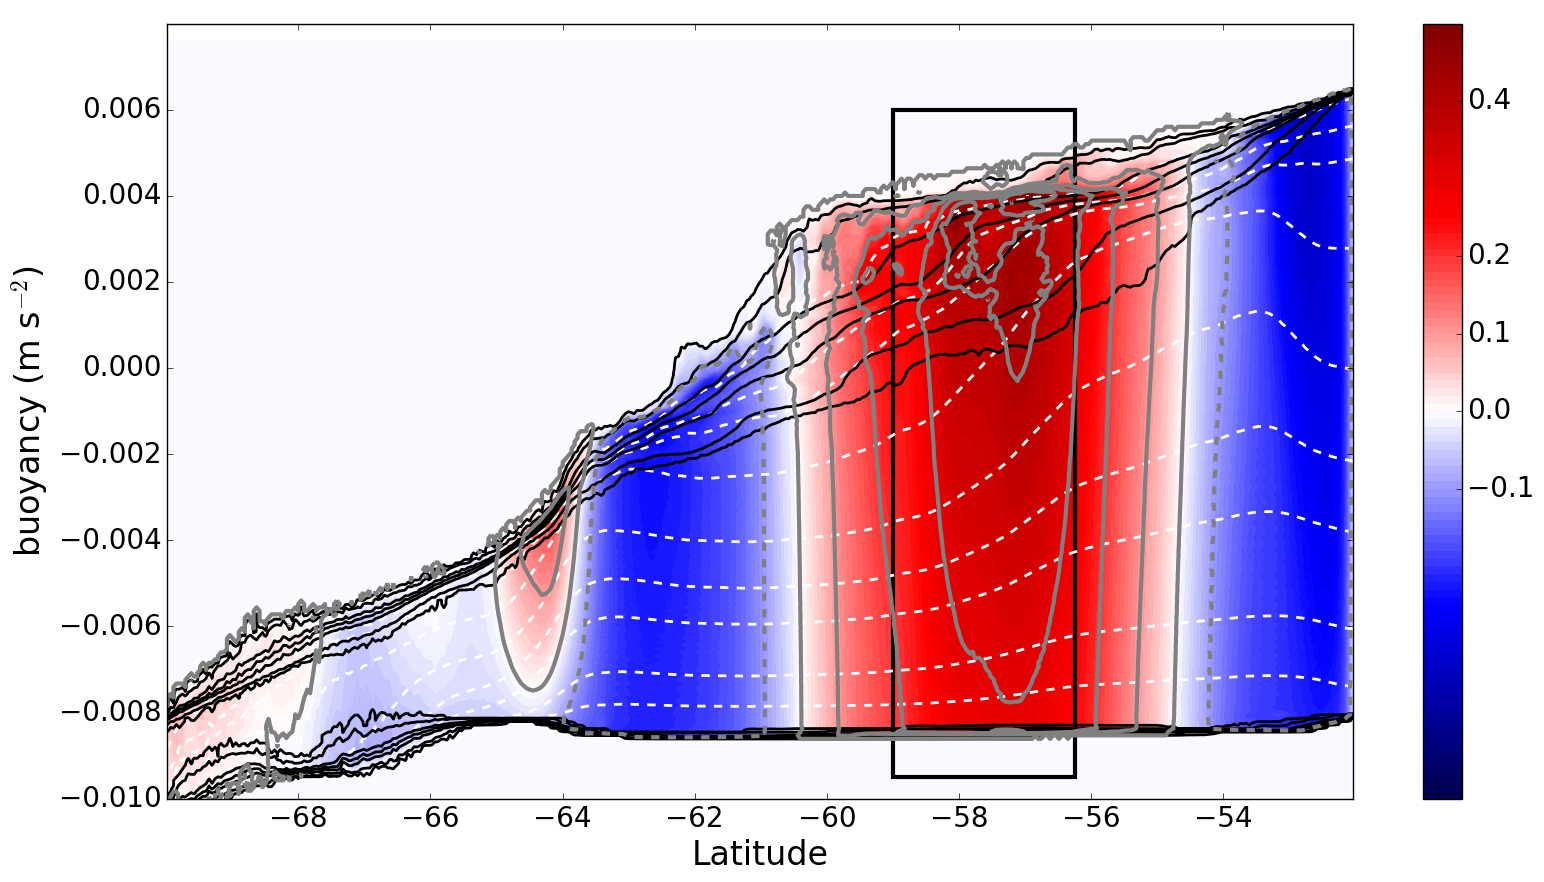

In [28]:
#Plot uTWA
boxRange_xAxisMin = -59.
boxRange_xAxisMax = -56.25
boxRange_yAxisMin = -0.0095
boxRange_yAxisMax = 0.006

colorLevels_buoyancyMaskEA = linspace(-0.1, 1.0, 111)
contourLevels_buoyancyMaskEA = [0.001, 0.01, 0.10, 0.25, 0.50, 0.95, 0.999]

scaling = 1.0e-2
uTWALevels = linspace(-50.0, 50.0, 101)
uTWATicks = [-0.1, 0, 0.1, 0.2, 0.4]
uTWALevels = np.multiply(uTWALevels, scaling)
uTWAContours = [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4]

heightContours = [-2000, -1500, -1000, -750, -500, -250, -100, -50, -10]

plt.contourf(binCenterLatitude*rtd, buoyancy, binned_uTWA.T, cmap=plt.cm.seismic, levels=uTWALevels);
plt.colorbar(orientation='vertical', fraction=0.1, extend='both', ticks=uTWATicks);
plt.contour(binCenterLatitude*rtd, buoyancy, binnedheightMidBuoyCoorEA.T, levels=heightContours, colors='white', linewidths=2);
plt.contour(binCenterLatitude*rtd, buoyancy, binned_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=2);
plt.contour(binCenterLatitude*rtd, buoyancy, binned_uTWA.T, levels=uTWAContours, colors='gray', linewidths=3);
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m s$^{-2}$)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax - boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

(400, 250)


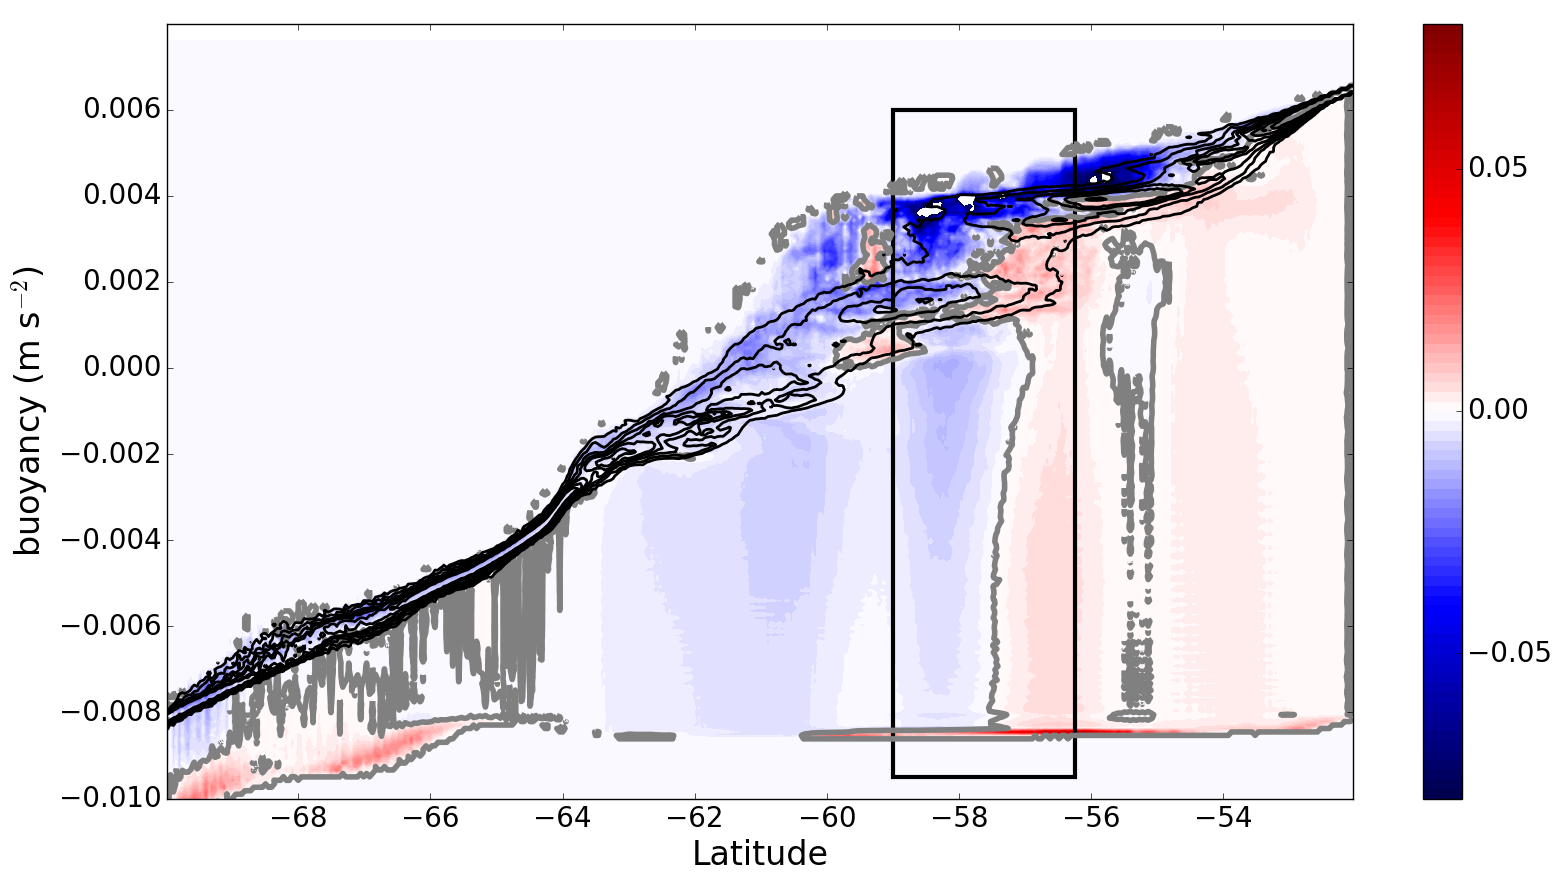

In [29]:

scaling = 1.0e-2
vTWALevels = linspace(-8.0, 8.0, 81)
vTWATicks = [-0.05, 0, 0.05]
vTWALevels = np.multiply(vTWALevels, scaling)
vTWAContours = [0.0]

#find how often a given layer is at the surface
atSfc = np.zeros_like(buoyancyMaskEA)

#compute frequency at surface by comparing buoyancy mask at adjacent levels
for iBuoyancy in range(0,nBuoyancyLevels-1):
    atSfc[:,iBuoyancy]=buoyancyMaskEA[:,iBuoyancy+1] - buoyancyMaskEA[:,iBuoyancy]

atSurface = bin_fields2(binningDict, atSfc, nBinsLatitude, nBuoyancyLevels)

atSurfaceColors = linspace(0.0, 0.1, 101)
atSurfaceContours = [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2]

#eliminate values at outcropping at bottom of domain
workZeros = np.zeros_like(atSurface)
atSurface = np.where(atSurface>0, atSurface, workZeros)
print atSurface.shape

plt.contourf(binCenterLatitude*rtd, buoyancy, binned_vTWA.T, cmap=plt.cm.seismic, levels=vTWALevels);
plt.colorbar(orientation='vertical', fraction=0.1, ticks=vTWATicks);
plt.contour(binCenterLatitude*rtd, buoyancy, binned_vTWA.T,levels=vTWAContours, colors='gray', linewidths=4);
plt.contour(binCenterLatitude*rtd, buoyancy, atSurface.T, levels=atSurfaceContours, colors='black', linewidths=2);
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m s$^{-2}$)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax - boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [76]:
(EPFT[0,inds,:,0,2]).max()

0.0

In [30]:
EPFT.shape

(3, 337528, 250, 3, 3)

done with EPFT average


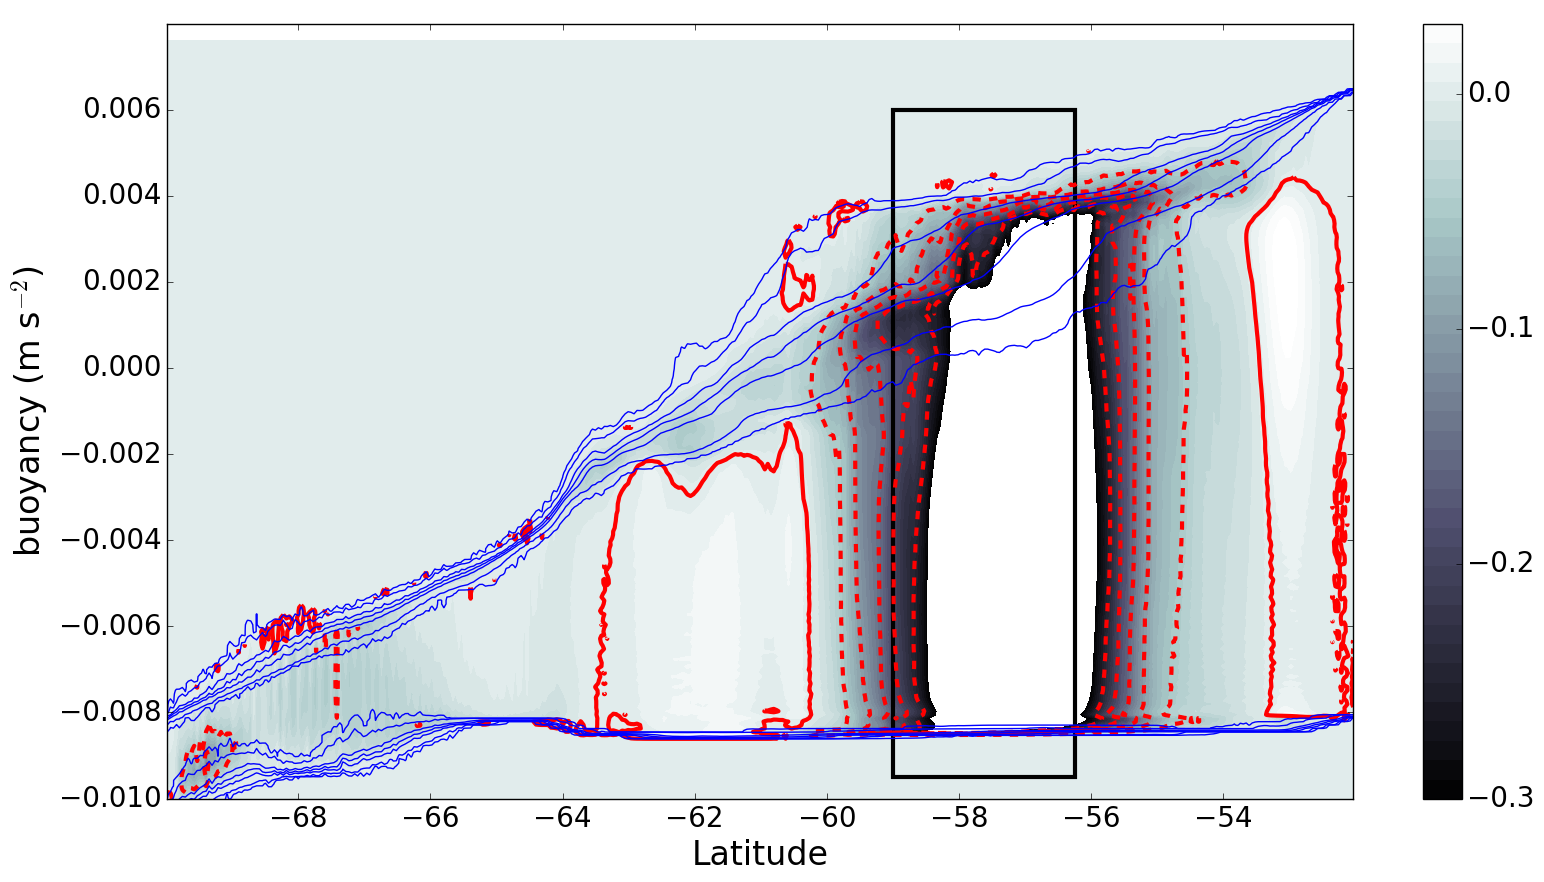

In [31]:
EPFT31 = np.array(EPFT[0,inds,:,0,2]);
sigmaEA = EPData.sigmaEA.values

binned_EPFT31 = bin_fields2(binningDict, EPFT31*sigmaEA, nBinsLatitude, nBuoyancyLevels)

#binned_EPFT31 = np.multiply(binned_EPFT31,oceanMask3)
print 'done with EPFT average'

config_density0 = 1026.0

binned_EPFT31 *= config_density0
#binned_EPFT31 = np.multiply(binned_EPFT31, binnedsigmaEA)

EPFT31Levels = linspace(-0.3, 0.03, 41)
EPFT31Ticks = [-0.3, -0.2, -0.1, 0]
EPFT31Contours = [-0.25, -0.2, -0.15, -0.1, -0.05, 0.0001]

lstyle = []
for lev in EPFT31Contours:
    if lev < 0:
        lstyle.append('dashed')
    else:
        lstyle.append('solid')
        #
plt.contourf(binCenterLatitude*rtd, buoyancy, binned_EPFT31.T, cmap=plt.cm.bone, levels=EPFT31Levels);
plt.colorbar(orientation='vertical', fraction=0.1, ticks=EPFT31Ticks);
plt.contour(binCenterLatitude*rtd, buoyancy, binned_EPFT31.T, levels=EPFT31Contours, colors='red', \
            linewidths=3, linestyles = lstyle);
plt.contour(binCenterLatitude*rtd, buoyancy, binned_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='blue', linewidths=1);
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m s$^{-2}$)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

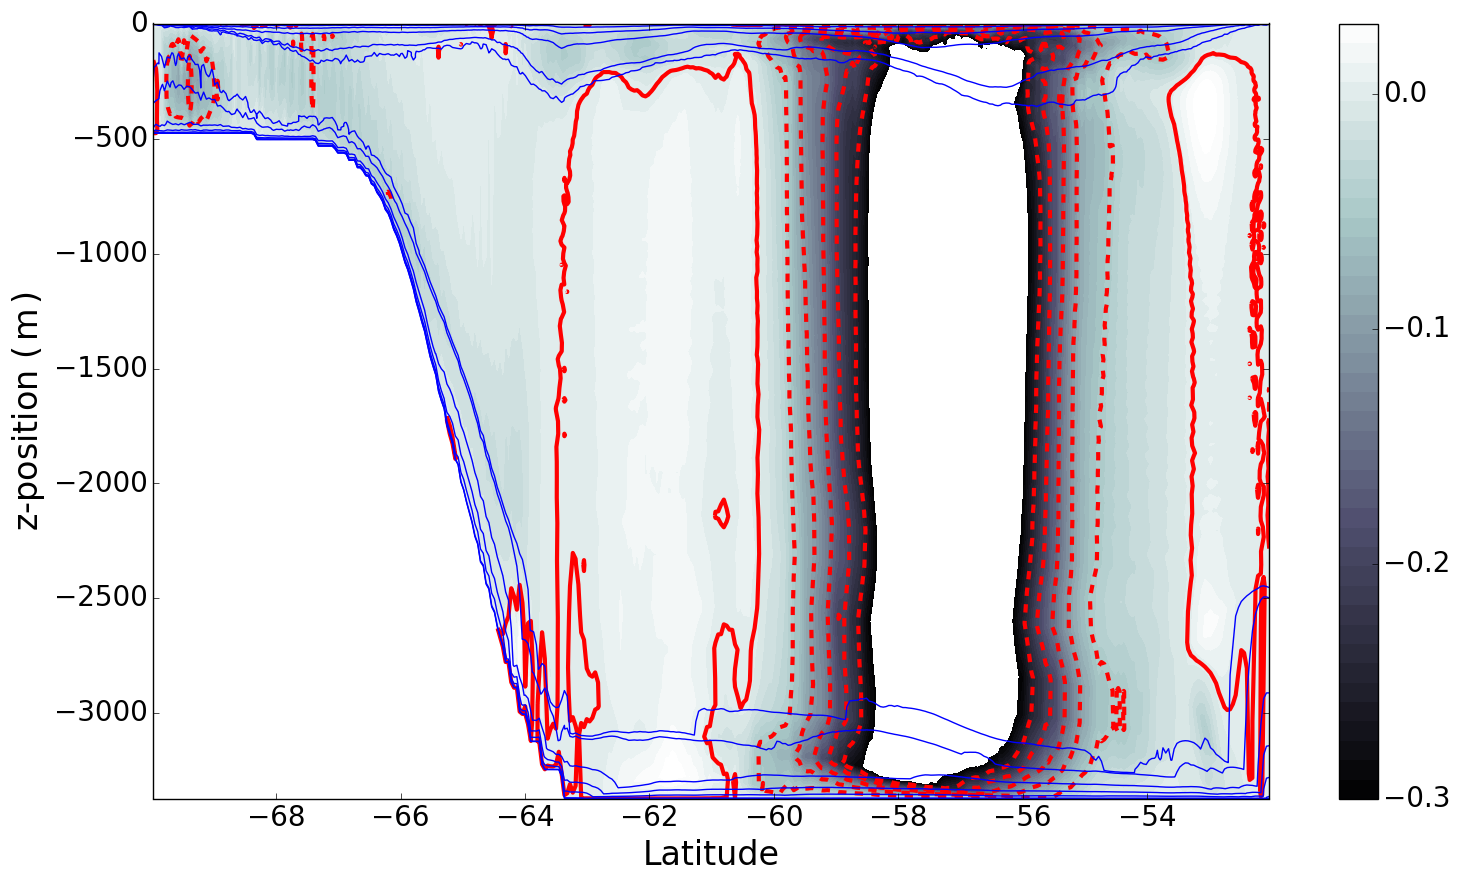

In [32]:
#EPFT31Levels = linspace(-0.0003, 0.00003, 61)
#EPFT31Ticks = [-0.0003, -0.0002, -0.0001, 0]
#EPFT31Contours = [-0.00025, -0.0002, -0.00015, -0.0001, -0.00005, 0.0000001]
#EPFT31Contours = linspace(-0.00030, 0, 51)

#binned_EPFT31 /= config_density0

yMap=zeros((nBinsLatitude,nBuoyancyLevels))
zMap=zeros((nBinsLatitude,nBuoyancyLevels))

heightMidBuoyCoorEA = EPData.heightMidBuoyCoorEA.values
binnedheightMidBuoyCoorEA = bin_fields2(binningDict, heightMidBuoyCoorEA, nBinsLatitude, nBuoyancyLevels)

pData = binnedheightMidBuoyCoorEA

for j in range(0,nBinsLatitude):
    for k in range(0,nBuoyancyLevels):
        yMap[j,k]=binCenterLatitude[j]
        zMap[j,k]=pData[j,k]
        
plt.contourf(yMap*rtd, zMap, binned_EPFT31, cmap=plt.cm.bone, levels=EPFT31Levels);
plt.colorbar(orientation='vertical', ticks=EPFT31Ticks);
plt.contour(yMap*rtd, zMap, binned_EPFT31, levels=EPFT31Contours, colors='red', linewidths=3, linestyles=lstyle);
plt.contour(yMap*rtd, zMap, binned_buoyancyMaskEA, levels=contourLevels_buoyancyMaskEA, colors='blue', linewidths=1);
plt.xlabel("Latitude", **axis_font)
plt.ylabel('z-position ($ \, $m$ \, $)', **axis_font)


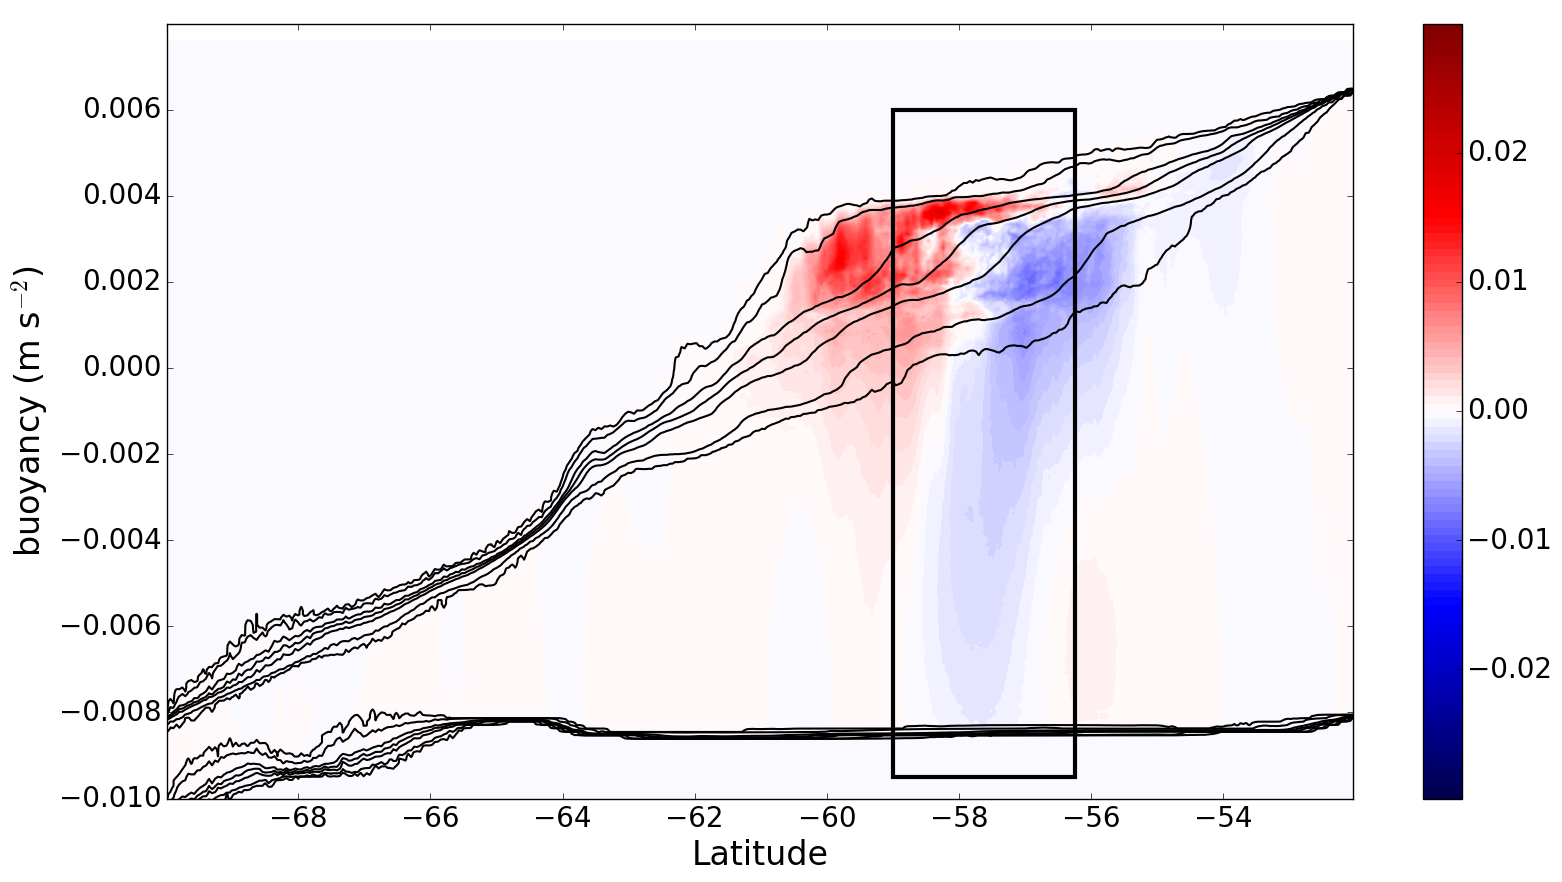

In [34]:
#Plot meridional flux of zonal momentum
EPFT21 = np.array(EPFT[0,inds,:,0,1]);
binned_EPFT21 = bin_fields2(binningDict, EPFT21, nBinsLatitude, nBuoyancyLevels)

EPFT21Levels = linspace(-0.03, 0.03, 101)
EPFT21Contours = [-0.02, -0.01, 0, 0.01, 0.02]


maskLevels = [0.001, 0.01, 0.1, 0.25, 0.5, 0.95]

plt.contourf(binCenterLatitude*rtd, buoyancy, binned_EPFT21.T, cmap=plt.cm.seismic, levels=EPFT21Levels);
plt.colorbar(orientation='vertical', fraction=0.1, ticks=EPFT21Contours);
plt.contour(binCenterLatitude*rtd, buoyancy, binned_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=1.5);
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m s$^{-2}$)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [ ]:
#Start Computing the horizontally averaged momentum balance
#
#

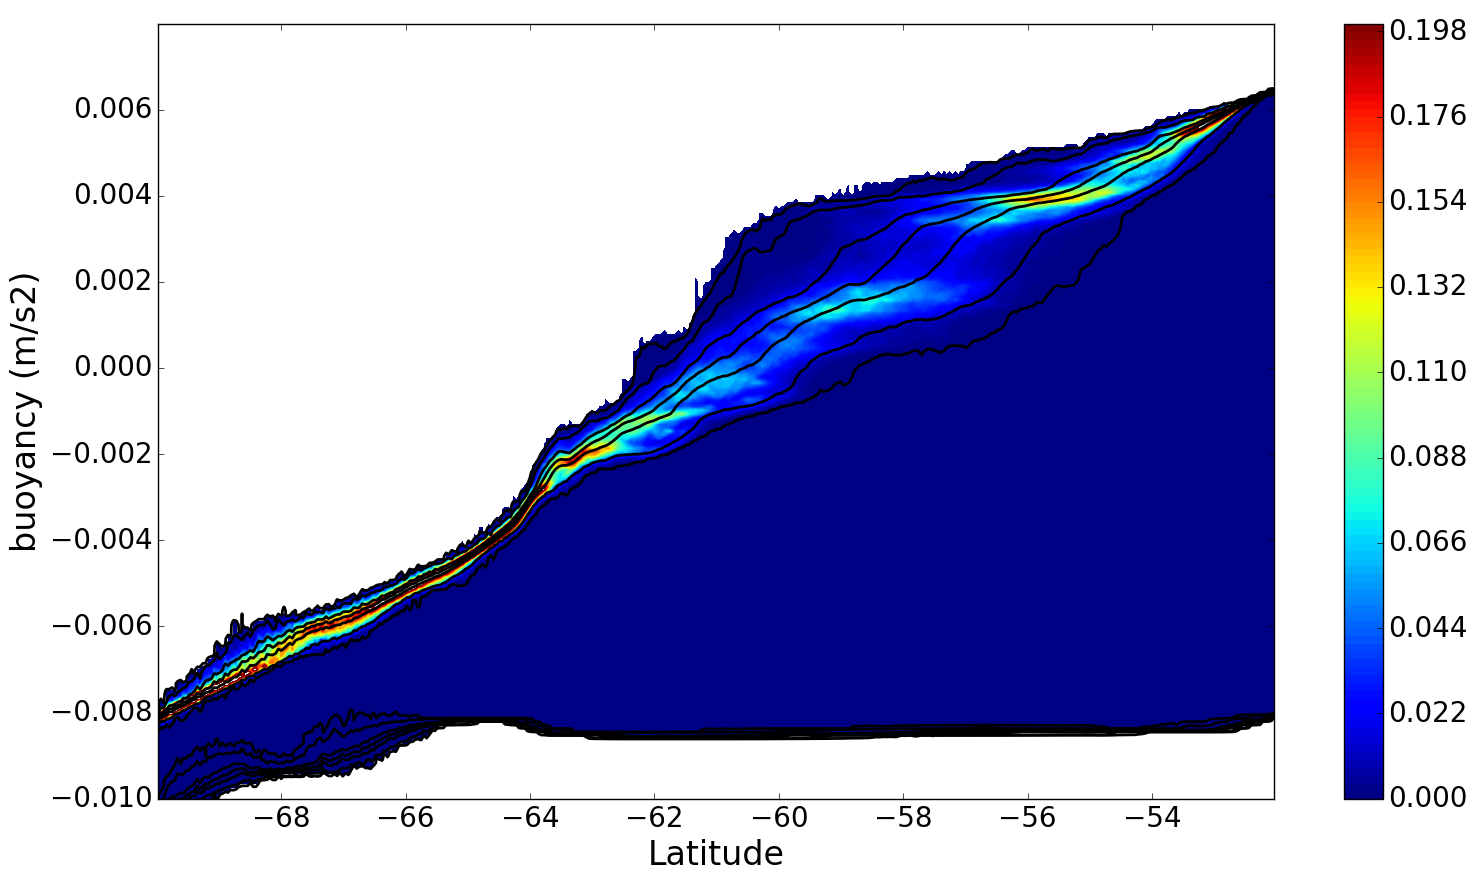

In [35]:
#Form array of probabilities at surface

atSurface = np.zeros_like(binned_buoyancyMaskEA)

for iBuoyancy in range(0,nBuoyancyLevels-1):
    atSurface[:,iBuoyancy] = binned_buoyancyMaskEA[:,iBuoyancy+1] - binned_buoyancyMaskEA[:,iBuoyancy]
    
workZeros = np.zeros_like(atSurface)
atSurface = np.where(atSurface > 0, atSurface, workZeros)

atSurfaceColors = linspace(0.0, 0.2, 101)
atSurfaceContours = [0.01, 0.03, 0.05, 0.07, 0.09, .11]

plt.contourf(binCenterLatitude*rtd, buoyancy, atSurface.T/(1e-15+oceanMask.T),levels=atSurfaceColors);
plt.colorbar();
plt.contour(binCenterLatitude*rtd, buoyancy, binned_buoyancyMaskEA.T, levels=contourLevels_buoyancyMaskEA, colors='black', linewidths=2);
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

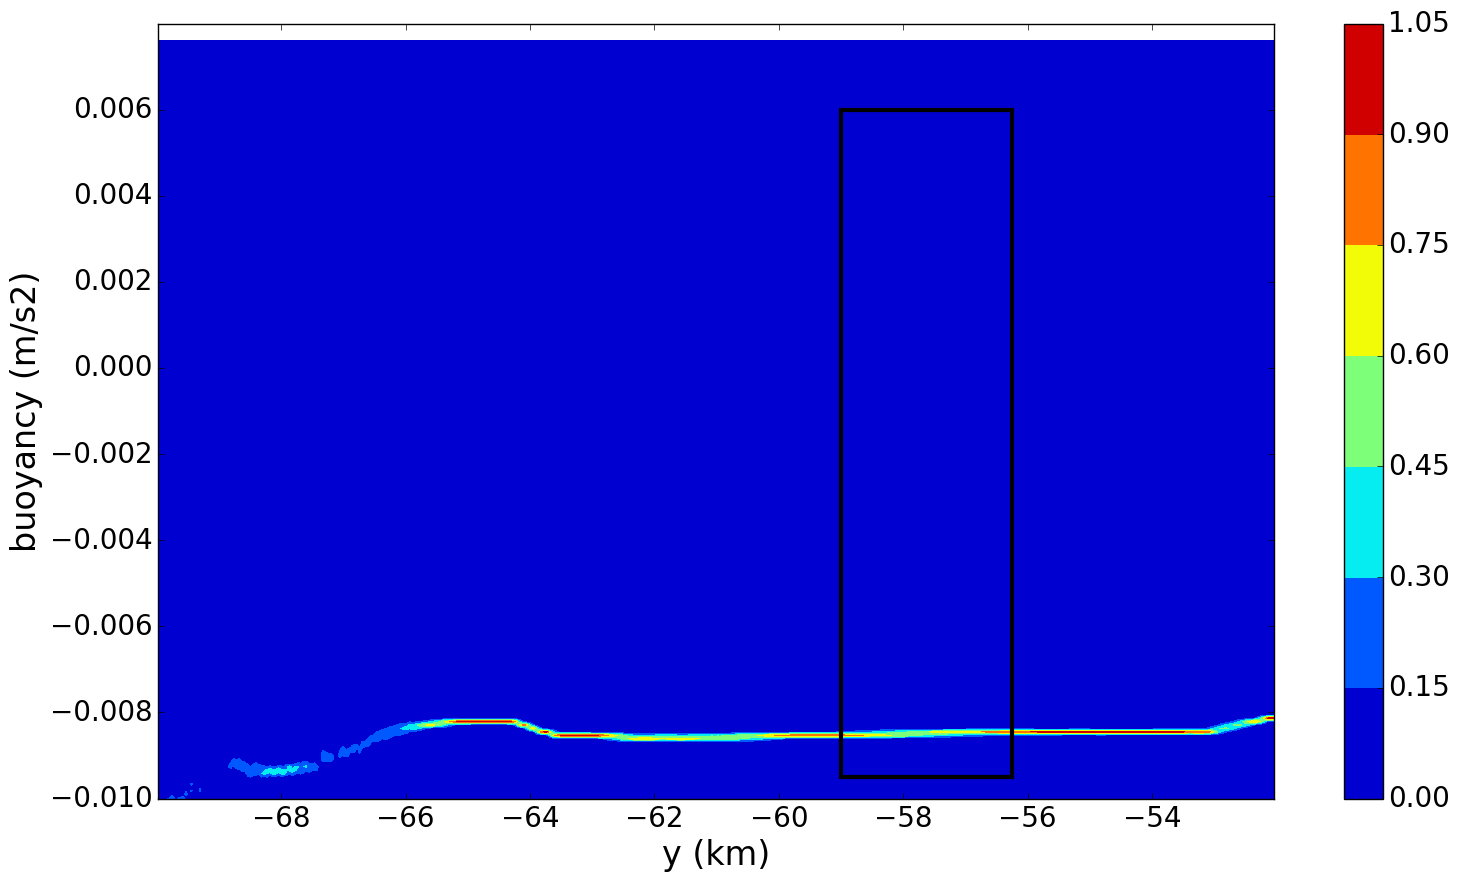

In [36]:
atBottom = np.zeros_like(binned_buoyancyMaskEA)

for iBuoyancy in range(nBuoyancyLevels-1,0,-1):
    atBottom[:,iBuoyancy] = binned_buoyancyMaskEA[:,iBuoyancy-1] - binned_buoyancyMaskEA[:,iBuoyancy]
    np.zeros_likeike = np.zeros_like(atBottom)
atBottom = np.where(atBottom > 0, atBottom, workZeros)

atBottomColors = linspace(0.0, 0.1, 101)
#atBottomContours = [0.01, 0.03, 0.05, 0.07, 0.09, .11]

plt.contourf(binCenterLatitude*rtd, buoyancy, atBottom.T);
plt.colorbar();
plt.ylim(-0.01, 0.008)
plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

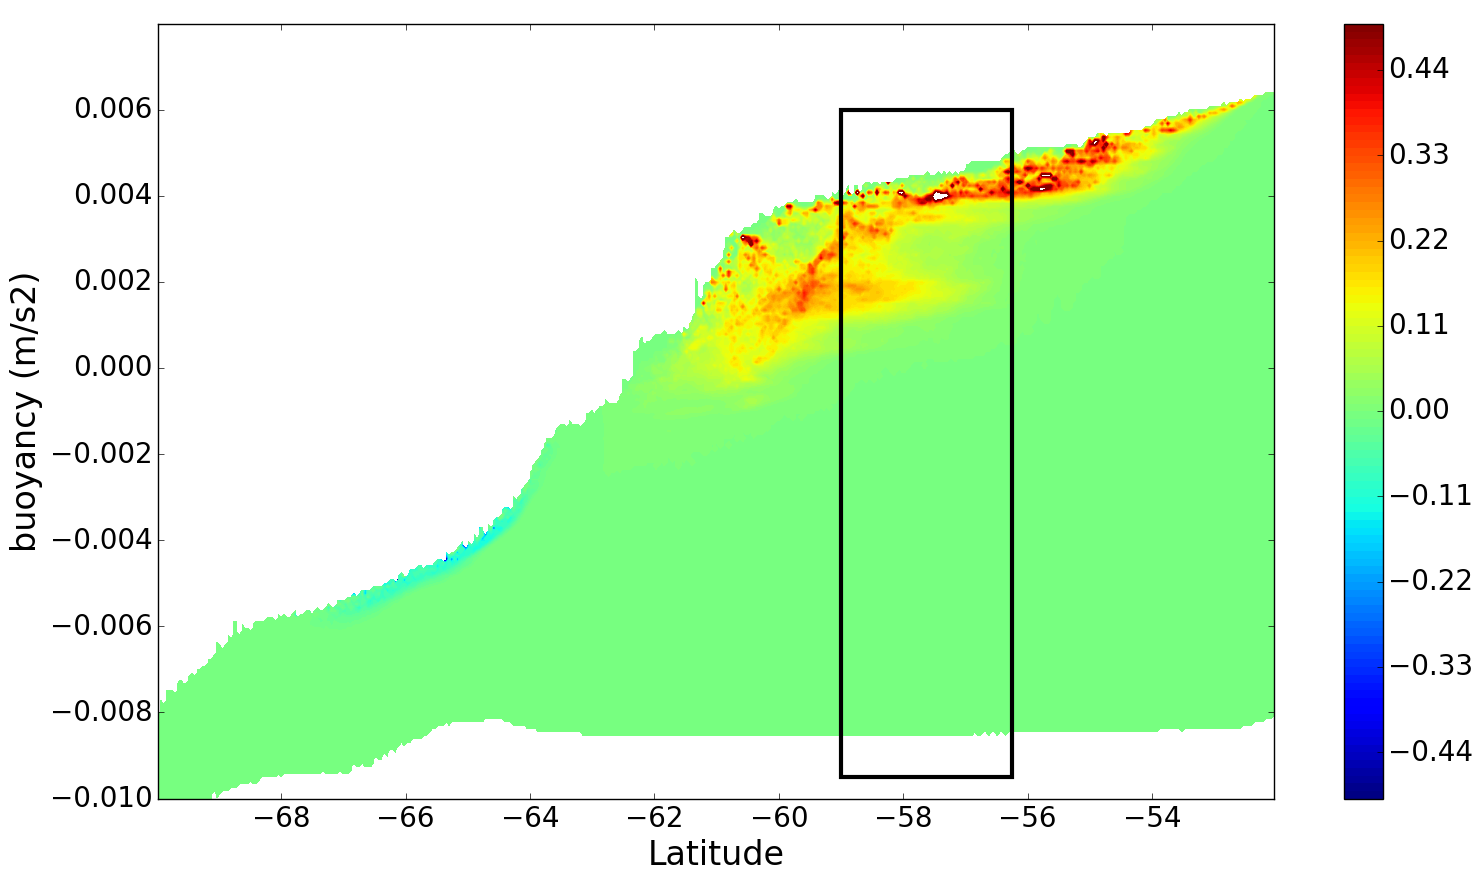

In [37]:
#get windstress zonal

windStressZonal = forcingData.windStressZonal.values / config_density0
binned_wsZonal = bin_fields2(binningDict, windStressZonal.T, nBinsLatitude, 1)

binned_wsZonal = np.divide(binned_wsZonal, config_density0)
buoyancyMaskEA = EPData.buoyancyMaskEA.values
atSurface = zeros_like(buoyancyMaskEA)
for iBuoyancy in range(0,nBuoyancyLevels-1):
    atSurface[:,iBuoyancy]=buoyancyMaskEA[:,iBuoyancy+1]-buoyancyMaskEA[:,iBuoyancy]

workZeros = zeros_like(atSurface)
atSurface = np.where(atSurface>0, atSurface, workZeros)

workBig = np.ones_like(buoyancyMaskEA)*1.0E10

sigmaEA = EPData.sigmaEA.values
sigmaEA = np.where(buoyancyMaskEA > threshold, sigmaEA, workBig)
binnedsigmaEA = bin_fields2(binningDict, sigmaEA, nBinsLatitude, nBuoyancyLevels)

db = np.zeros_like(potentialDensityTopRef)
for iBuoyancy in range(0,nBuoyancyLevels-1):
    db[iBuoyancy] = potentialDensityTopRef[iBuoyancy+1] - potentialDensityTopRef[iBuoyancy]
    
db[nBuoyancyLevels-1] = db[nBuoyancyLevels-2]

db = db * gravity / config_density0

windStressZonalLayer = np.zeros_like(atSurface)
for iBuoyancy in range(0,nBuoyancyLevels-1):
    windStressZonalLayer[:,iBuoyancy] = np.multiply(windStressZonal[0,:], atSurface[:,iBuoyancy])
    windStressZonalLayer[:,iBuoyancy] = np.divide(windStressZonalLayer[:,iBuoyancy], sigmaEA[:,iBuoyancy])
    windStressZonalLayer[:,iBuoyancy] = np.divide(windStressZonalLayer[:,iBuoyancy], db[iBuoyancy])
    
windStressZonalLayer = np.multiply(windStressZonalLayer,oceanMask2)

bwindStressZonalLayer = bin_fields2(binningDict, windStressZonalLayer, nBinsLatitude, nBuoyancyLevels)

windStressZonalLayer = bwindStressZonalLayer
windStressZonalLayerColors = linspace(-0.5, 0.5, 101)
windStressZonalLayerContours = [-0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]

plt.contourf(binCenterLatitude*rtd, buoyancy, 86400*windStressZonalLayer.T / oceanMask.T, levels=windStressZonalLayerColors);
plt.colorbar();
plt.contour(binCenterLatitude*rtd, buoyancy, windStressZonalLayer.T, levels=windStressZonalLayerContours, linewidths=2, colors='k');
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [38]:
uusigEA = EPData.uusigmaEA.values
binneduuEA = bin_fields2(binningDict, uusigEA, nBinsLatitude, nBuoyancyLevels)

print 'done with uu'
vvsigEA = EPData.vvsigmaEA.values
binnedvvEA = bin_fields2(binningDict, vvsigEA, nBinsLatitude, nBuoyancyLevels)

print 'done with vv'



done with uu
done with vv


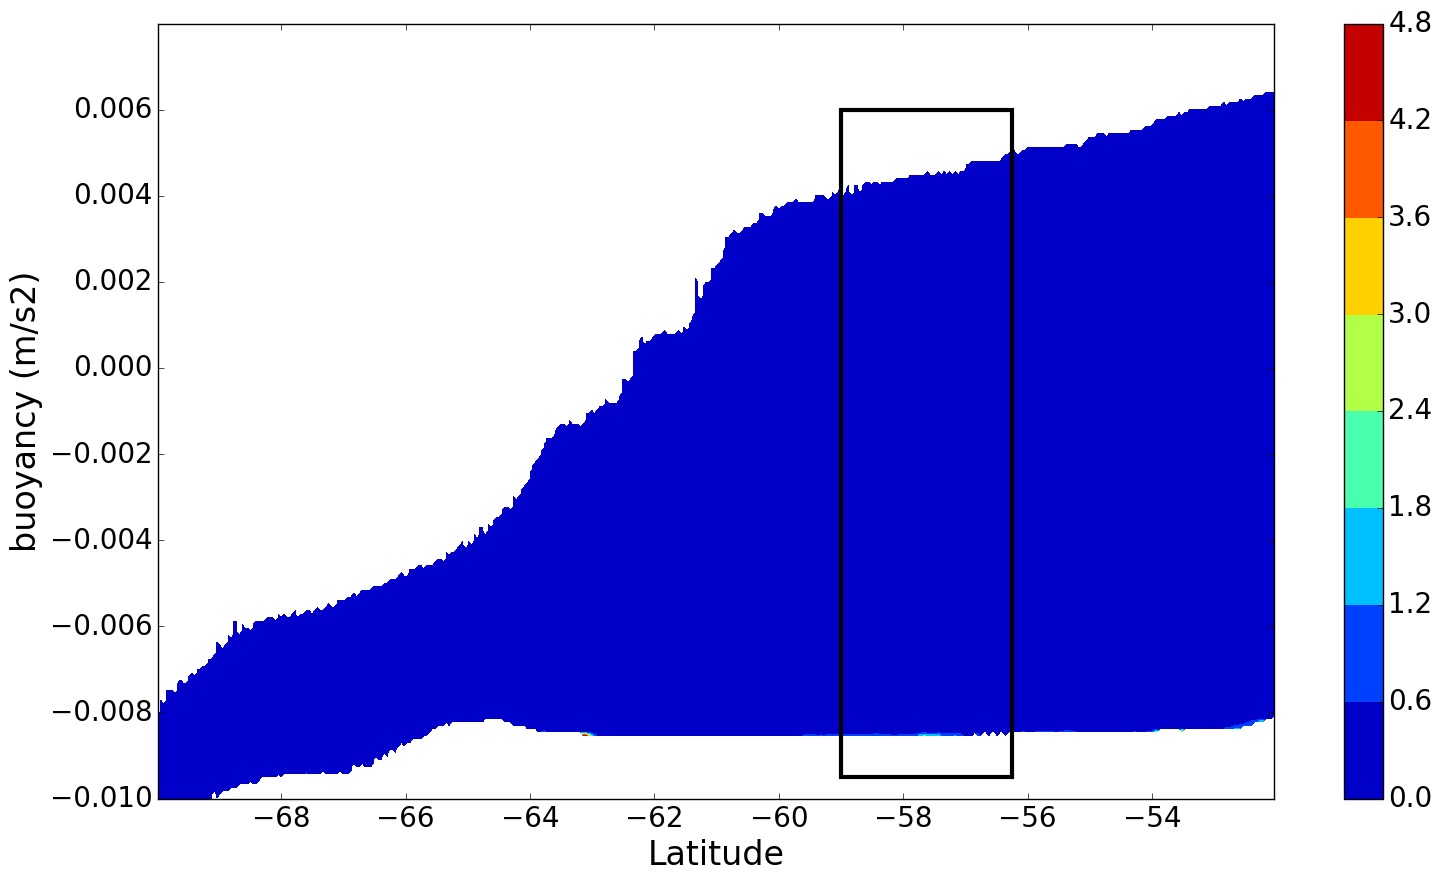

In [39]:


atSurface = zeros_like(buoyancyMaskEA)
for iBuoyancy in range(0,nBuoyancyLevels-1):
    atSurface[:,iBuoyancy]=buoyancyMaskEA[:,iBuoyancy+1]-buoyancyMaskEA[:,iBuoyancy]

workZeros = zeros_like(atSurface)
atSurface = np.where(atSurface>0, atSurface, workZeros)

atBottom = np.zeros_like(buoyancyMaskEA)

for iBuoyancy in range(nBuoyancyLevels-1,0,-1):
    atBottom[:,iBuoyancy] = buoyancyMaskEA[:,iBuoyancy-1] - buoyancyMaskEA[:,iBuoyancy]

atBottom = np.where(atBottom > 0, atBottom, workZeros)


workBig = ones_like(atSurface)*1.0E10
sigmaEA = EPData.sigmaEA.values
sigmaEA = np.where(buoyancyMaskEA>threshold, sigmaEA, workBig)

work1 = zeros_like(uTWA)
work1 = np.multiply (uTWA, uTWA)
work1 = np.divide(work1, sigmaEA)

#work2 = bin_fields2(binningDict, work1, nBinsLatitude, nBuoyancyLevels)
#work1 = work2


bottomDrag = zeros_like(atSurface)

#comp buoy width
db = zeros_like(potentialDensityTopRef)
for iBuoyancy in range(0,nBuoyancyLevels-1):
    db[iBuoyancy] = potentialDensityTopRef[iBuoyancy+1] - potentialDensityTopRef[iBuoyancy]

db[nBuoyancyLevels-1] = db[nBuoyancyLevels-2]
db = db * gravity / config_density0

dz = zeros_like(uTWA)
for iBuoyancy in range(1, nBuoyancyLevels-1):
    dz[:,iBuoyancy] = np.subtract(heightMidBuoyCoorEA[:,iBuoyancy-1], heightMidBuoyCoorEA[:,iBuoyancy+1])
    dz[:,iBuoyancy] = np.multiply(dz[:,iBuoyancy],0.5)
    bottomDrag[:,iBuoyancy] = np.divide(work1[:,iBuoyancy],db[iBuoyancy])
    
dz = np.where(buoyancyMaskEA > threshold, dz, workBig)

bottomDrag = np.multiply(bottomDrag, atBottom)
bottomDrag = 3E-3 * bottomDrag

bottomDrag = np.multiply(bottomDrag,oceanMask2)

dz = np.multiply(dz,oceanMask2)

temp = bin_fields2(binningDict, dz, nBinsLatitude, nBuoyancyLevels)
dz = temp

temp = bin_fields2(binningDict, bottomDrag, nBinsLatitude, nBuoyancyLevels)
bottomDrag = temp

plt.contourf(binCenterLatitude*rtd, buoyancy, bottomDrag.T / oceanMask.T * 86400)
plt.colorbar()
plt.ylim(-0.01,0.008)

plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

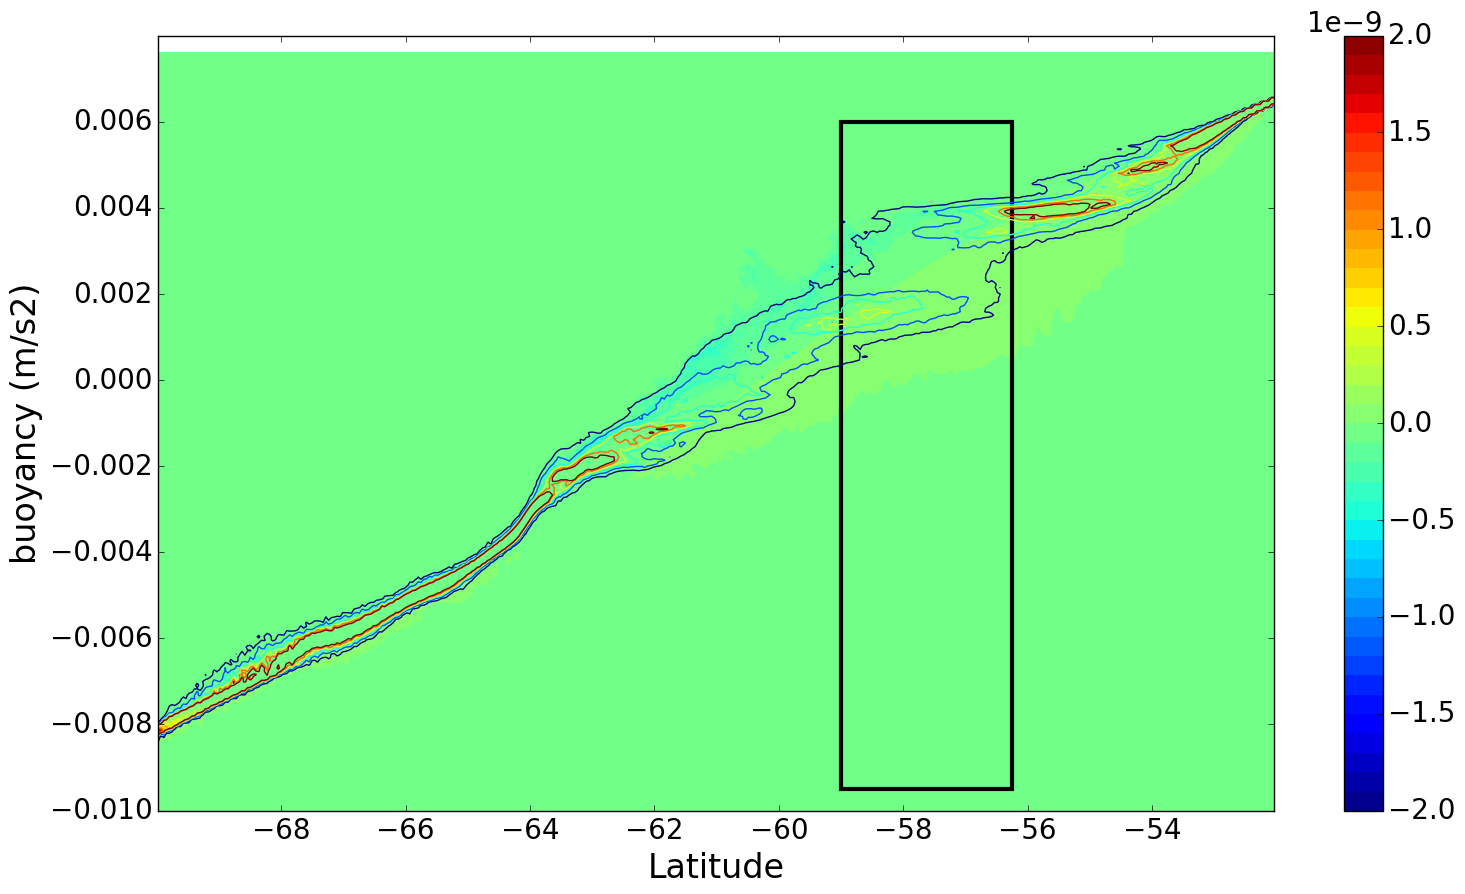

In [40]:
temperatureSurfaceRestoringValue = forcingData.temperatureSurfaceRestoringValue.values
#binned_tempSRV = bin_fields(nBinsLatitude, 1, \
#                                  maskLatitude, temperatureSurfaceRestoringValue.T)

temperaturePistonVelocity = forcingData.temperaturePistonVelocity.values
#binned_tempPV = bin_fields(nBinsLatitude, 1, \
#                                  maskLatitude, temperaturePistonVelocity.T)

workRef = np.zeros_like(buoyancyMaskEA)
for iBuoyancy in range(0,nBuoyancyLevels):
    workRef[:,iBuoyancy] = temperatureRef[iBuoyancy]
    
bDot = zeros_like(buoyancyMaskEA)
for iBuoyancy in range(0, nBuoyancyLevels):
    bDot[:,iBuoyancy] = -(workRef[:,iBuoyancy] - temperatureSurfaceRestoringValue[0,:])
    bDot[:,iBuoyancy] = np.multiply(bDot[:,iBuoyancy], temperaturePistonVelocity[0,:])
    bDot[:,iBuoyancy] = bDot[:,iBuoyancy] * config_eos_linear_alpha
    bDot[:,iBuoyancy] = np.multiply(bDot[:,iBuoyancy], atSurface[:,iBuoyancy])
    bDot[:,iBuoyancy] = gravity / config_density0 * bDot[:,iBuoyancy]
    
for iBuoyancy in range(0, nBuoyancyLevels):
    dz = np.multiply(db[iBuoyancy], sigmaEA[:,iBuoyancy])
    bDot[:,iBuoyancy] = np.divide(bDot[:,iBuoyancy], dz[:])

#bDot = np.multiply(bDot,oceanMask2)

temp = bin_fields2(binningDict, bDot, nBinsLatitude, nBuoyancyLevels)
bDot2 = temp

batSfc = bin_fields2(binningDict, atSurface, nBinsLatitude, nBuoyancyLevels)

scaling = 1E-9
bDotColorLevels = linspace(-2.0, 2.0, 41)
bDotColorLevels = scaling * bDotColorLevels

plt.contourf(binCenterLatitude*rtd, buoyancy, bDot2.T , levels=bDotColorLevels);
plt.colorbar();
plt.contour(binCenterLatitude*rtd, buoyancy, batSfc.T , levels=atSurfaceContours);
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

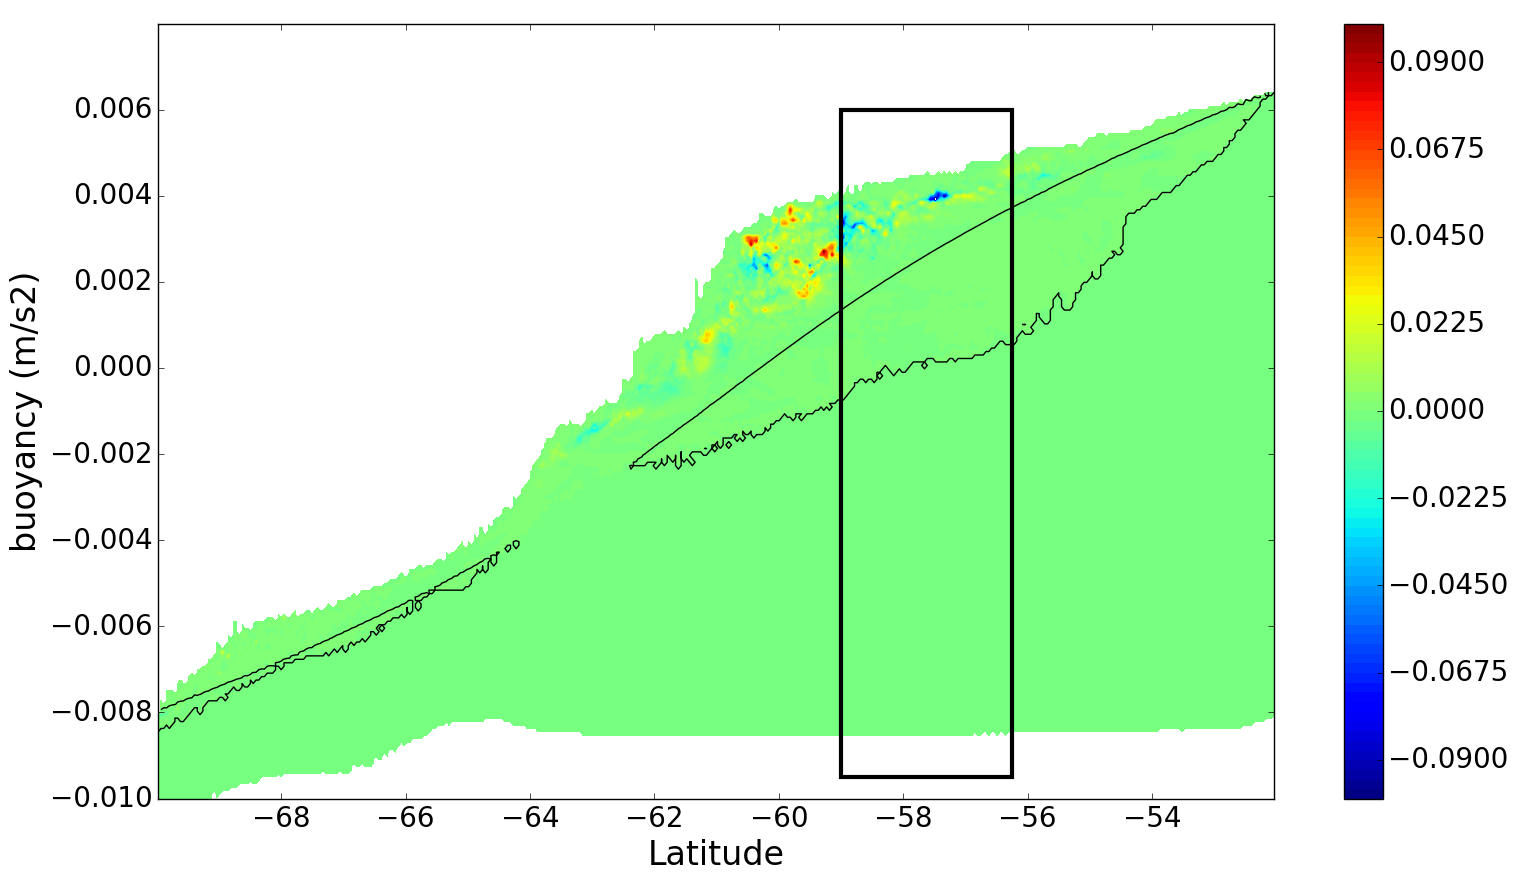

In [41]:
verticalAdvection = np.zeros_like(buoyancyMaskEA)

for iBuoyancy in range(1,nBuoyancyLevels-1):
    verticalAdvection[:,iBuoyancy] = (uTWA[:,iBuoyancy-1] - uTWA[:,iBuoyancy+1]) / db[iBuoyancy]
    verticalAdvection[:,iBuoyancy] = -np.multiply(verticalAdvection[:,iBuoyancy], bDot[:,iBuoyancy])

temp = bin_fields2(binningDict, verticalAdvection, nBinsLatitude, nBuoyancyLevels)
verticalAdvection = temp

sumData = 86400*verticalAdvection
sumDatabDot = 86400*bDot2

vvColorLevels = linspace(-0.1, 0.1, 81)
bDotContourLevels = linspace(-0.1, 0.1, 11)
plt.contourf(binCenterLatitude*rtd, buoyancy, sumData.T / oceanMask.T, levels=vvColorLevels);
plt.colorbar();
plt.contour(binCenterLatitude*rtd, buoyancy, sumDatabDot.T / oceanMask.T, levels=bDotContourLevels, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [321]:
#sigmaEA = EPData.sigmaEA.values

ErtelPV = EPData.ErtelPV.values
ErtelPV = np.multiply(ErtelPV, sigmaEA)

binnedEPVEA = bin_fields2(binningDict, ErtelPV, nBinsLatitude, nBuoyancyLevels)

fCell = initData.fCell.values
f2 = np.zeros((len(fCell),1))
f2[:,0] = fCell
binnedF = bin_fields2(binningDict, f2, nBinsLatitude, 1)

In [322]:
ErtelPV.max()

4.6502212252759166e+21

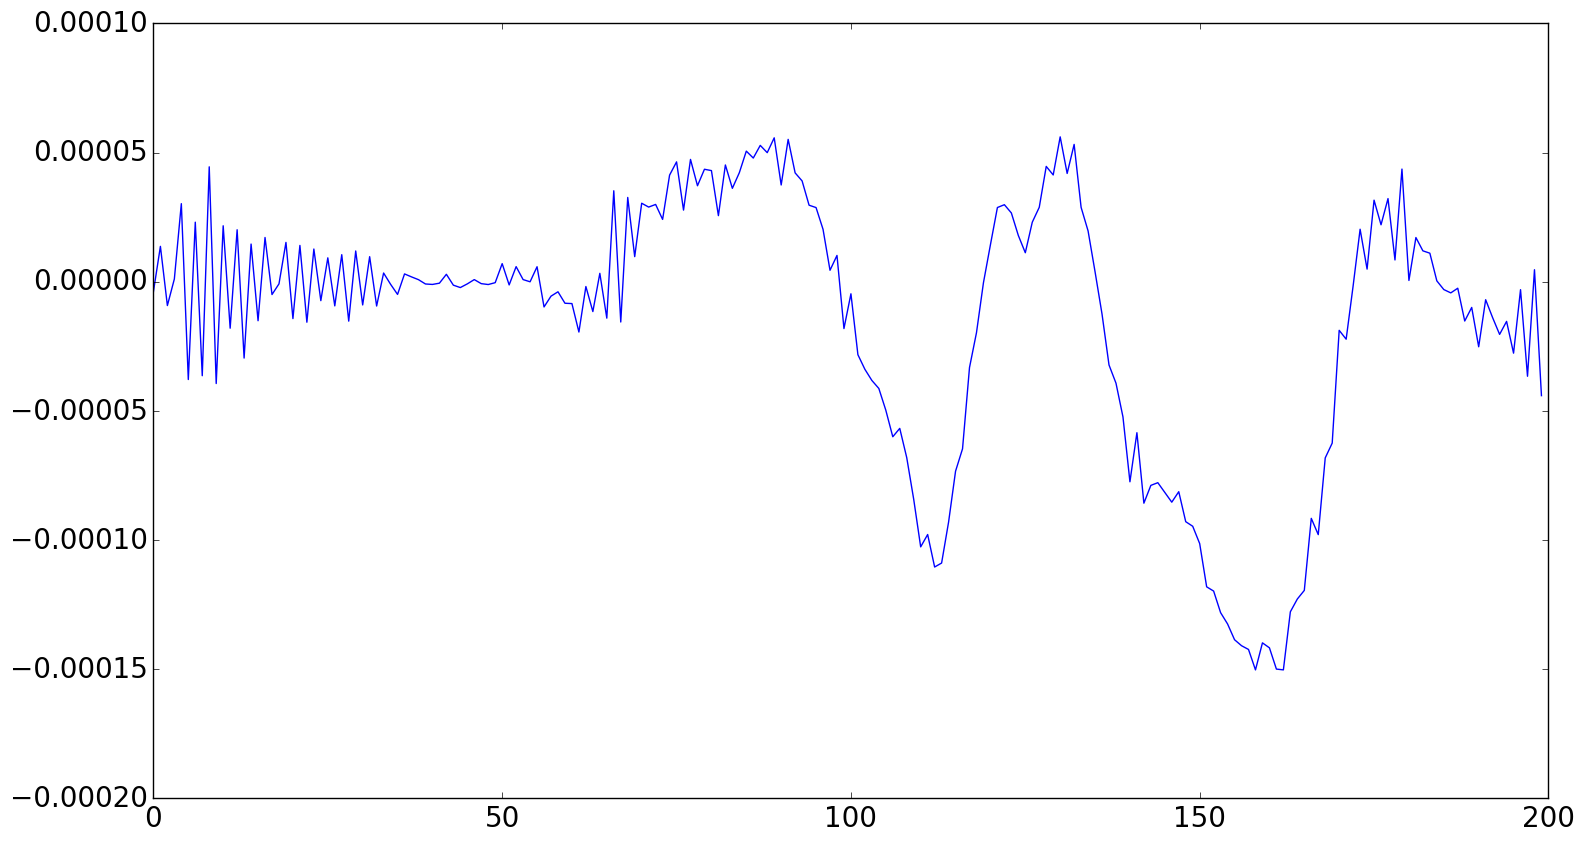

In [323]:
#Add Montgomery potential piece

montgomeryEAgradx = EPData.montgPotGradZonalEA.values

binnedMGP = bin_fields2(binningDict, montgomeryEAgradx, nBinsLatitude, nBuoyancyLevels)

bT = binnedMGP.sum(axis=1)
plt.plot(bT)

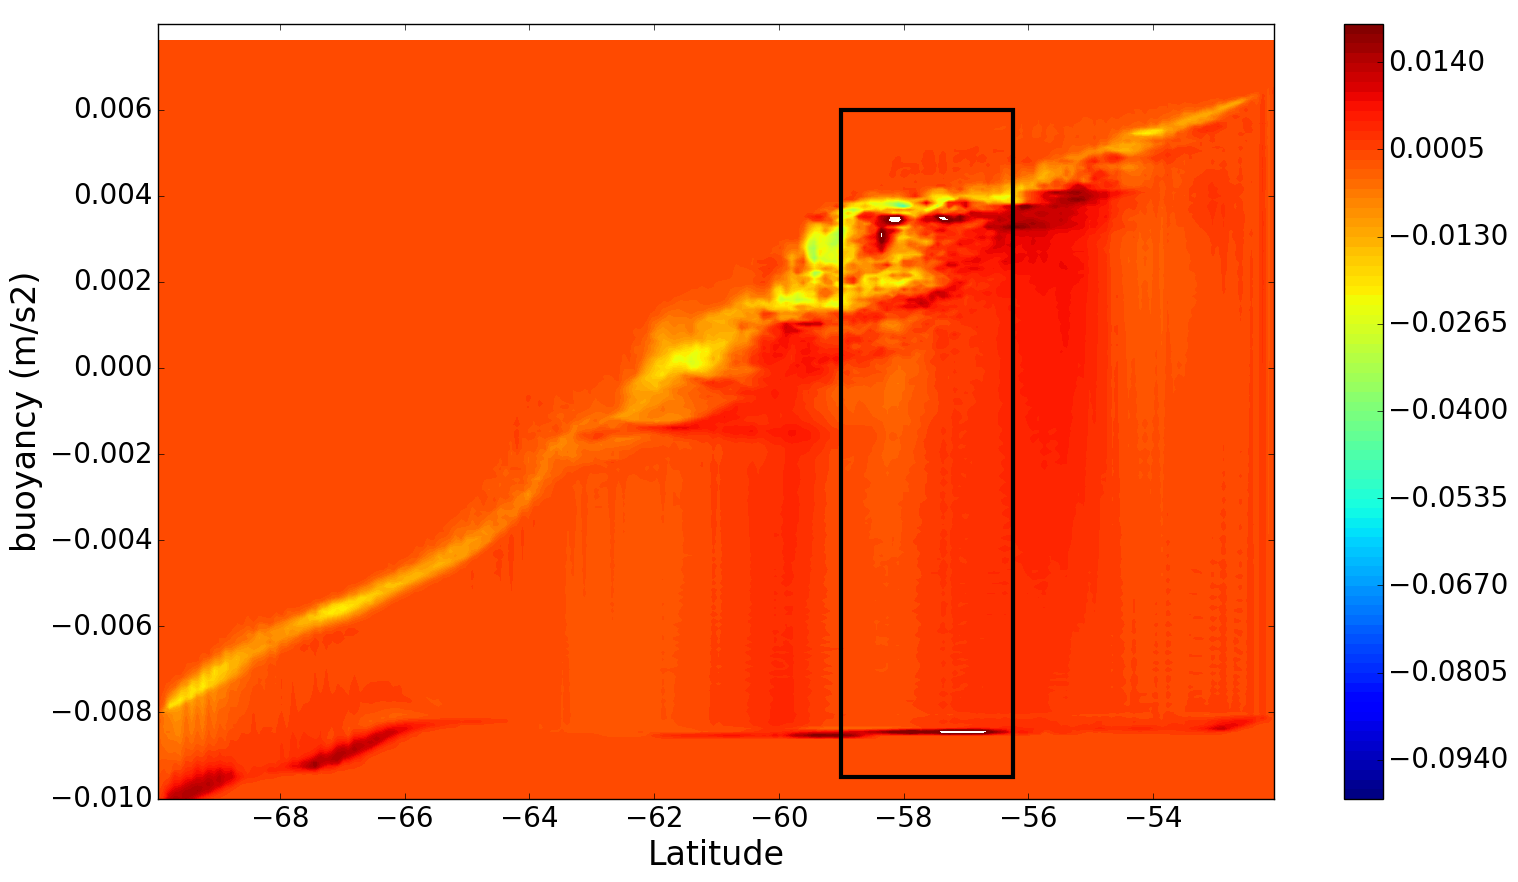

In [324]:
vTWA = EPData.vTWA.values
binned_vTWA = bin_fields2(binningDict, vTWA, nBinsLatitude, nBuoyancyLevels)

vTWAColorLevels = linspace(-0.1, 0.02, 81)
plt.contourf(binCenterLatitude*rtd, buoyancy, binned_vTWA.T, levels=vTWAColorLevels);
plt.colorbar();
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

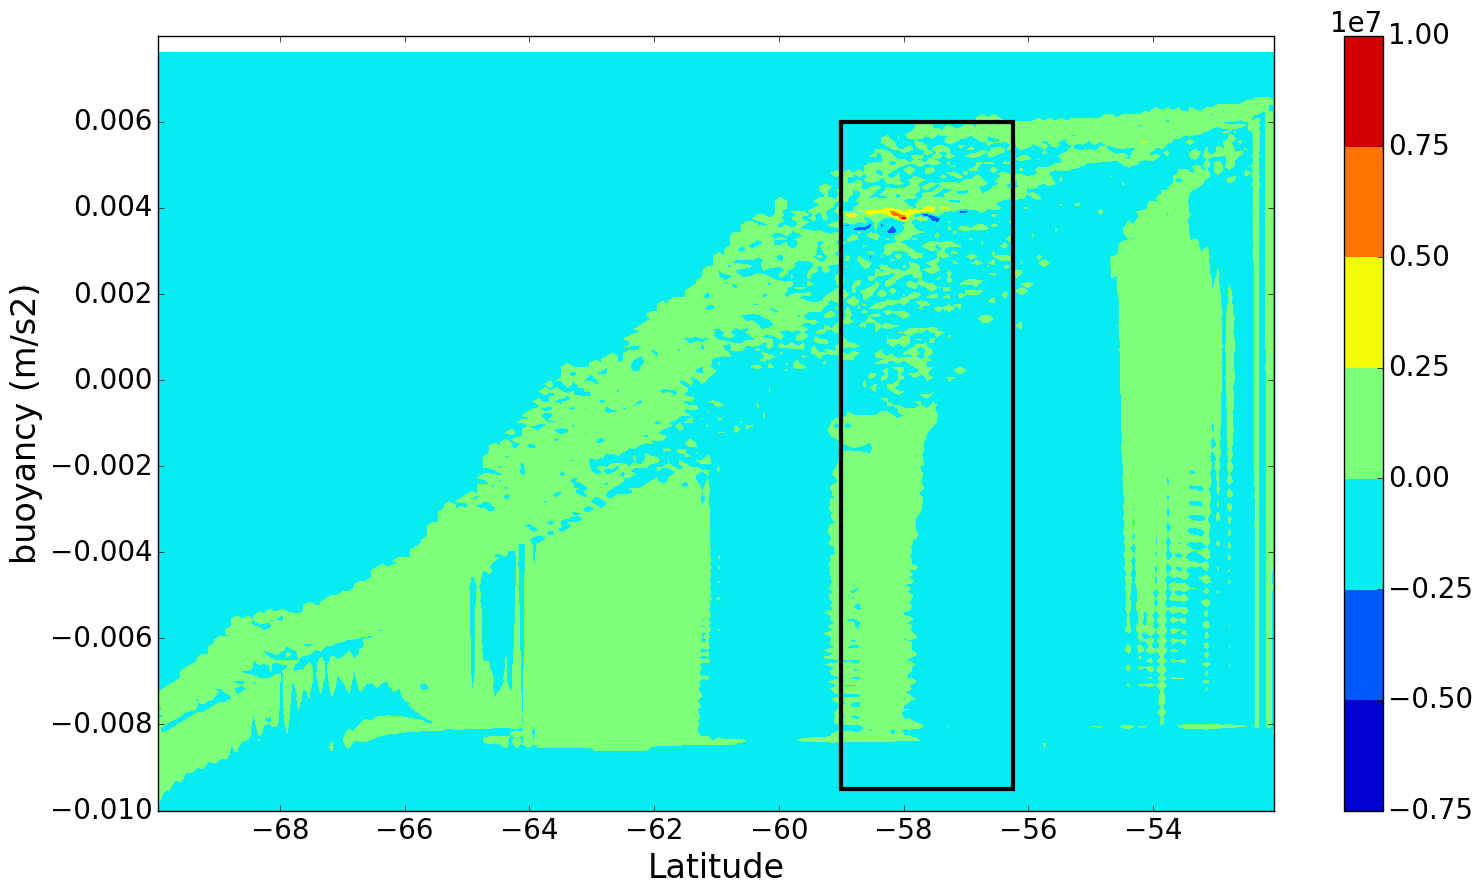

In [325]:
coriolisForce = zeros_like(vTWA)
for iBuoyancy in range(1,nBuoyancyLevels-1):
    coriolisForce[:,iBuoyancy] = np.multiply(vTWA[:,iBuoyancy], ErtelPV[:,iBuoyancy])

temp = bin_fields2(binningDict, coriolisForce, nBinsLatitude, nBuoyancyLevels)
coriolisForce = temp

vTWAColorLevels = linspace(-0.1, 0.02, 81)
plt.contourf(binCenterLatitude*rtd, buoyancy, 86400*coriolisForce.T);
plt.colorbar();
#plt.contour(binCenterLatitude*rtd, buoyancy, batSfc.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

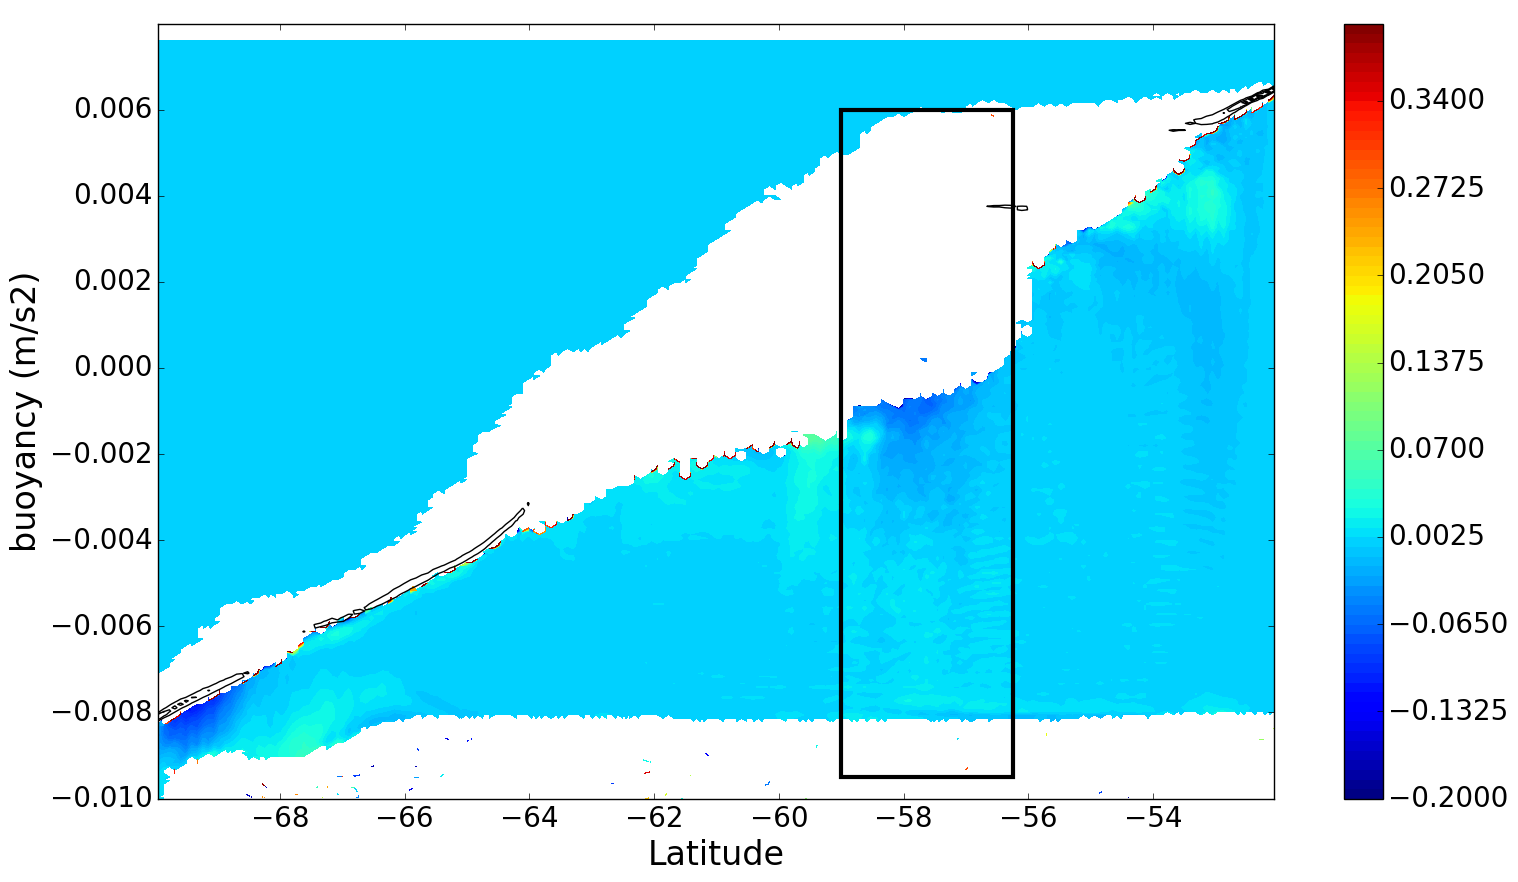

In [326]:
EPFT31 = EPFT[0,:,:,0,2]
EPFT31 = -EPFT31

EPFT31 = np.multiply(EPFT31,sigmaEA)

#EPFT31_2 = np.multiply(EPFT31_2,binnedsigmaEA)

eddyForcingVert = np.zeros_like(EPFT31)
for iBuoyancy in range(1,nBuoyancyLevels-1):
    eddyForcingVert[:,iBuoyancy] = (EPFT31[:,iBuoyancy-1] - EPFT31[:,iBuoyancy+1]) / db[iBuoyancy]

eddyForcingVert = np.divide(eddyForcingVert,sigmaEA)

temp = bin_fields2(binningDict, eddyForcingVert, nBinsLatitude, nBuoyancyLevels)
eddyForcingVert = temp

vertFluxColorLevels = linspace(-0.2, 0.4, 81)
plt.contourf(binCenterLatitude*rtd, buoyancy, 86400*eddyForcingVert.T, levels=vertFluxColorLevels);
plt.colorbar();
plt.contour(binCenterLatitude*rtd, buoyancy, batSfc.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

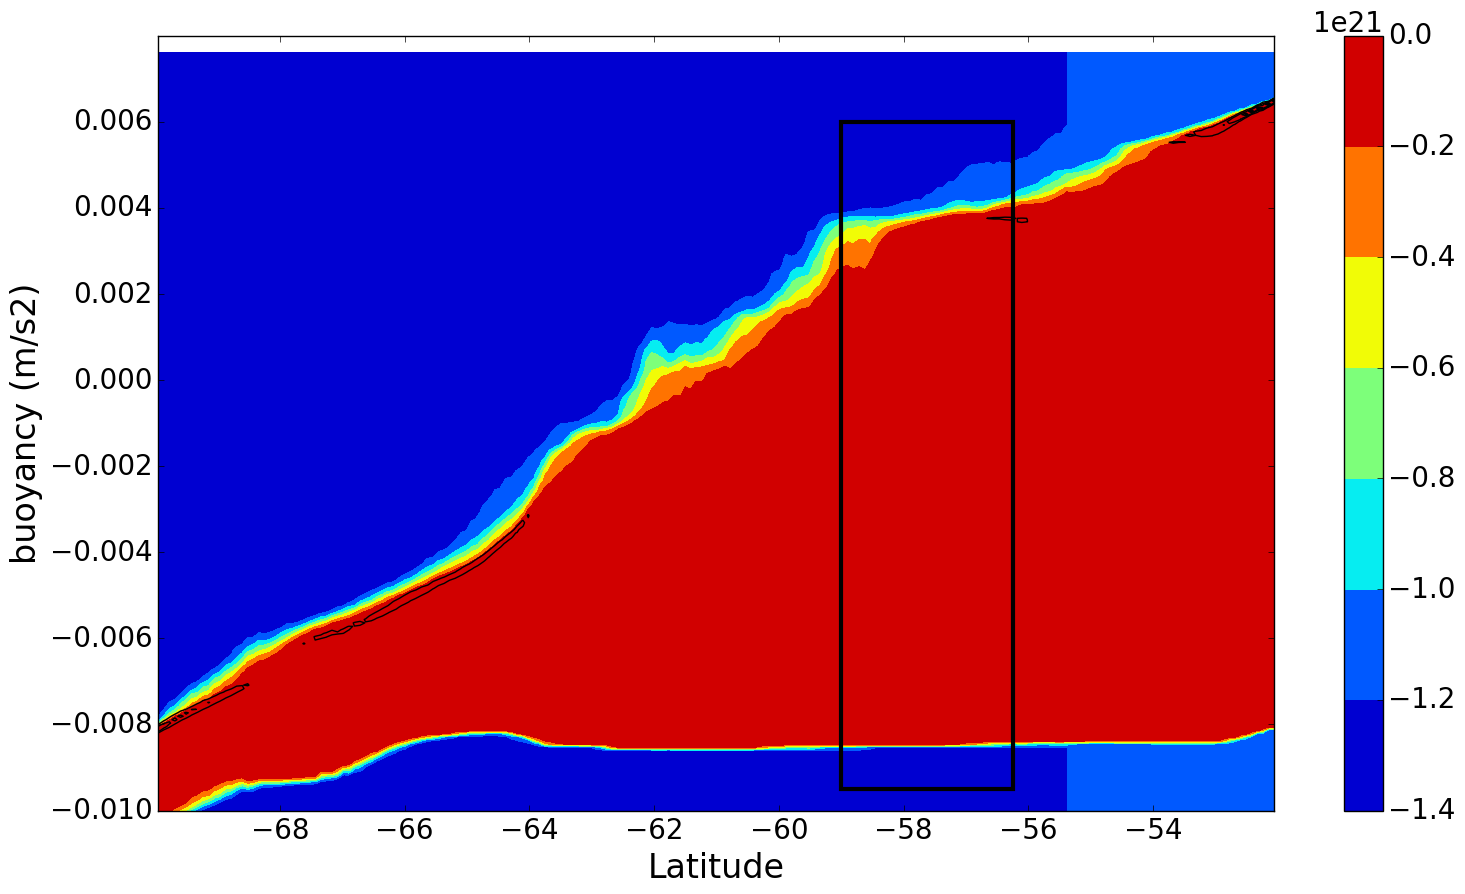

In [327]:
temp = bin_fields2(binningDict, ErtelPV, nBinsLatitude, nBuoyancyLevels)
bErtelPV = temp

vTWAColorLevels = linspace(-0.1, 0.02, 81)
plt.contourf(binCenterLatitude*rtd, buoyancy, bErtelPV.T);
plt.colorbar();
plt.contour(binCenterLatitude*rtd, buoyancy, batSfc.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [328]:
divEPFT = EPData.divEPFT[:,:,0].values
divE2 = np.multiply(divEPFT, oceanMask2)
binneddivE = bin_fields2(binningDict, divEPFT, nBinsLatitude, nBuoyancyLevels)



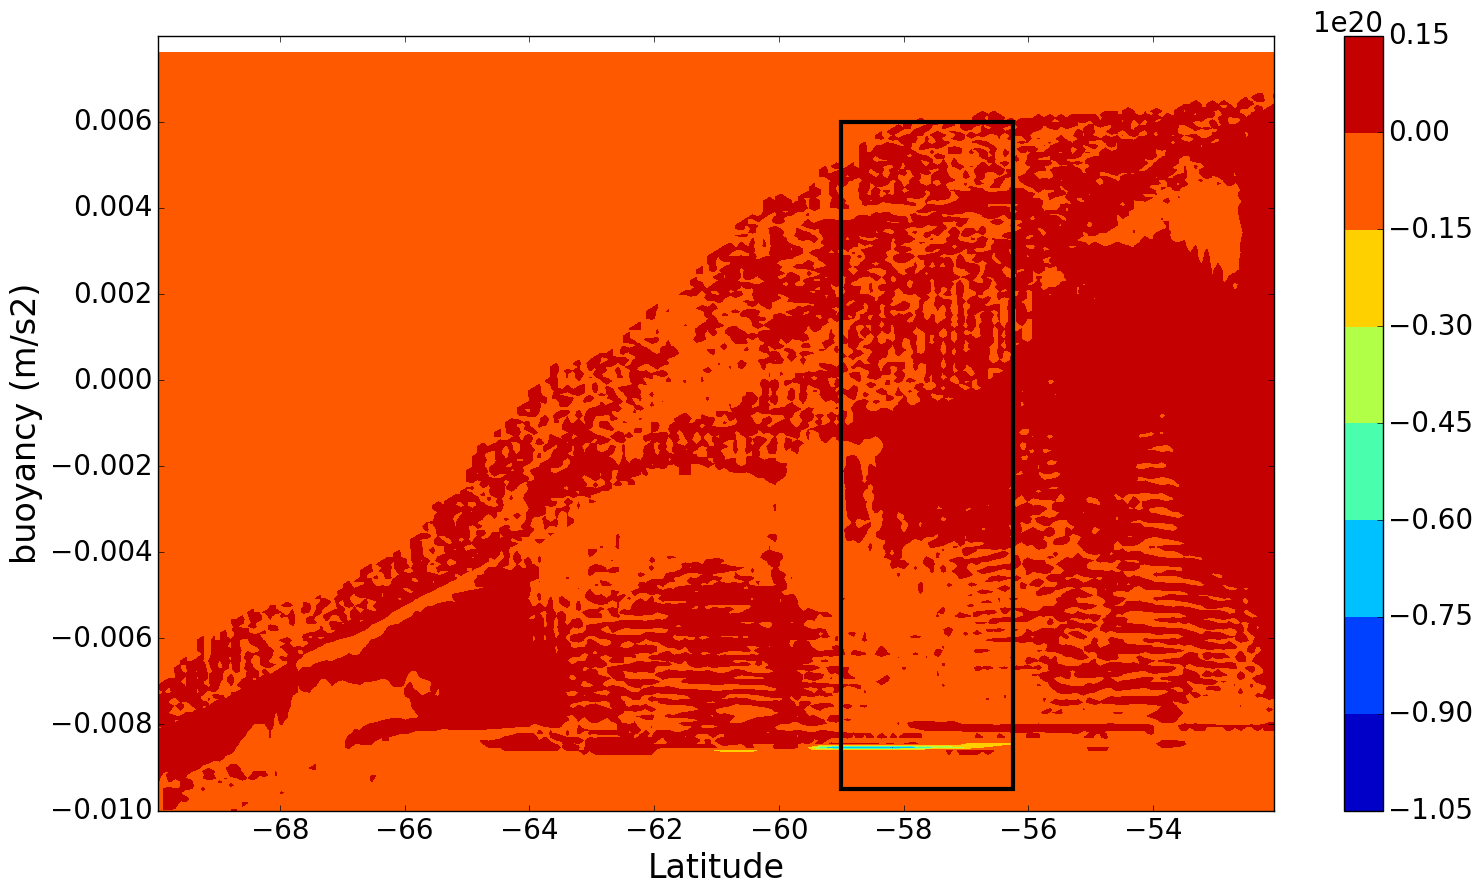

In [329]:
vertFluxColorLevels = linspace(-0.2, 0.4, 81)
plt.contourf(binCenterLatitude*rtd, buoyancy, 86400*binneddivE.T);
plt.colorbar();
#plt.contour(binCenterLatitude*rtd, buoyancy,oceanMask.T,colors='k')
#plt.contour(binCenterLatitude*rtd, buoyancy, atSurface.T, colors='black');
plt.ylim(-0.01, 0.008)
plt.xlabel("Latitude", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((boxRange_xAxisMin, boxRange_yAxisMin), \
                                boxRange_xAxisMax-boxRange_xAxisMin, boxRange_yAxisMax-boxRange_yAxisMin, \
                                fill=False, edgecolor="black", linewidth=3))

In [330]:
minIndex = abs(boxRange_xAxisMin/rtd - binCenterLatitude).argmin()
maxIndex = abs(boxRange_xAxisMax/rtd - binCenterLatitude).argmin()

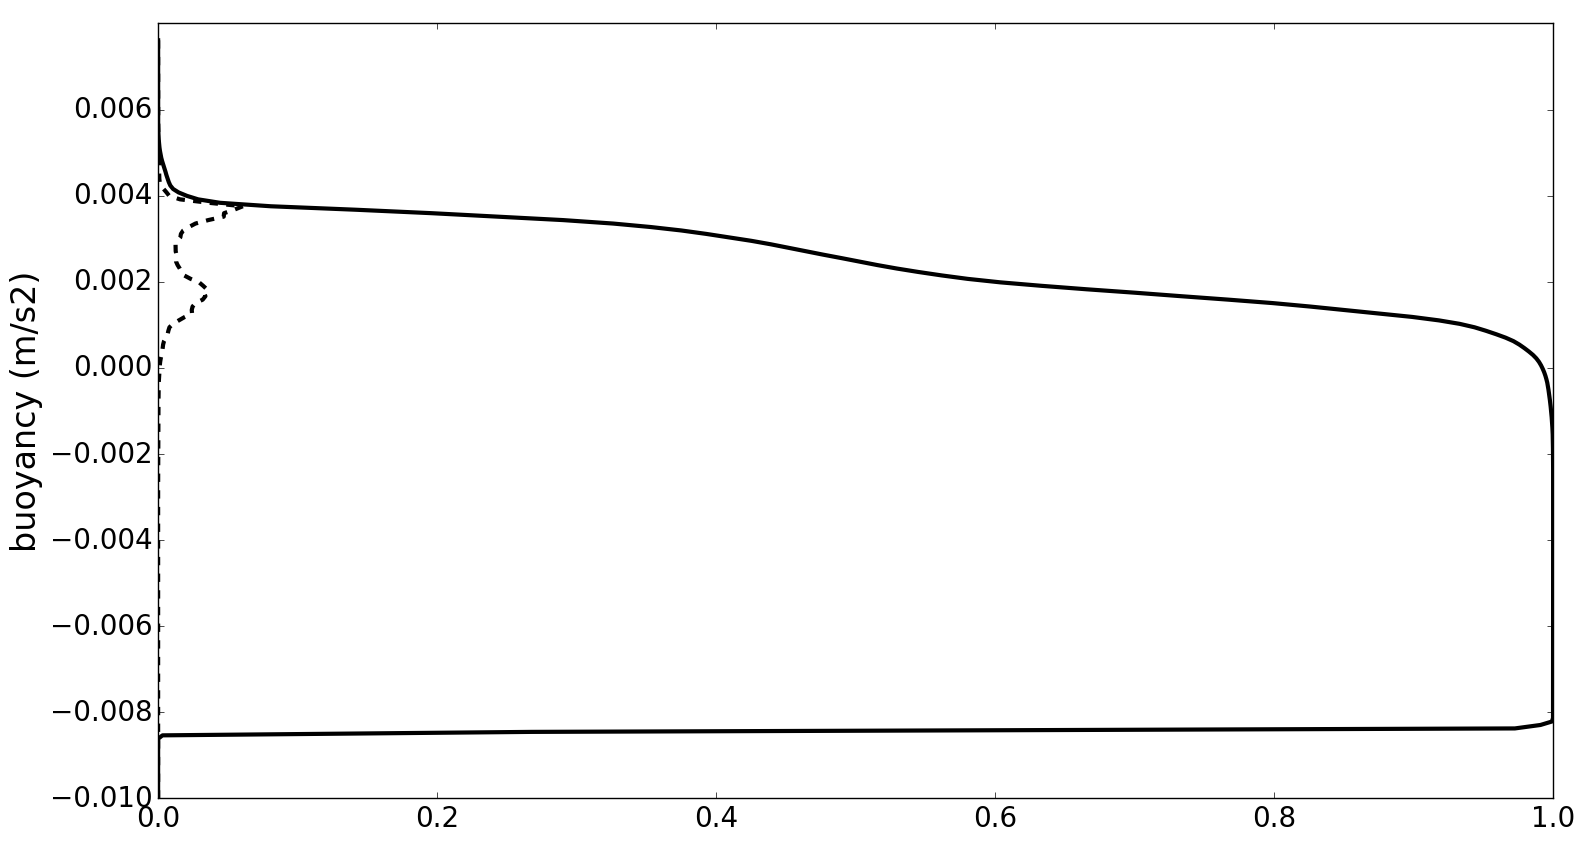

In [331]:
avg_buoyancyMaskEA = zeros_like(binned_buoyancyMaskEA)
avg_buoyancyMaskEA = binned_buoyancyMaskEA[minIndex:maxIndex+1,:]
sumData = avg_buoyancyMaskEA.mean(axis=0)
avg_buoyancyMaskEA = sumData

avg_atSurface = zeros_like(batSfc)
avg_atSurface = batSfc[minIndex:maxIndex+1,:]
sumData = avg_atSurface.mean(axis=0)
avg_atSurface = sumData

plt.plot(avg_buoyancyMaskEA, buoyancy, color='black', linewidth=3)
plt.plot(avg_atSurface, buoyancy, '--k', linewidth=3)
plt.ylim(-0.01, 0.008)
#plt.xlabel("y (km)", **axis_font)
plt.ylabel('buoyancy (m/s2)', **axis_font)

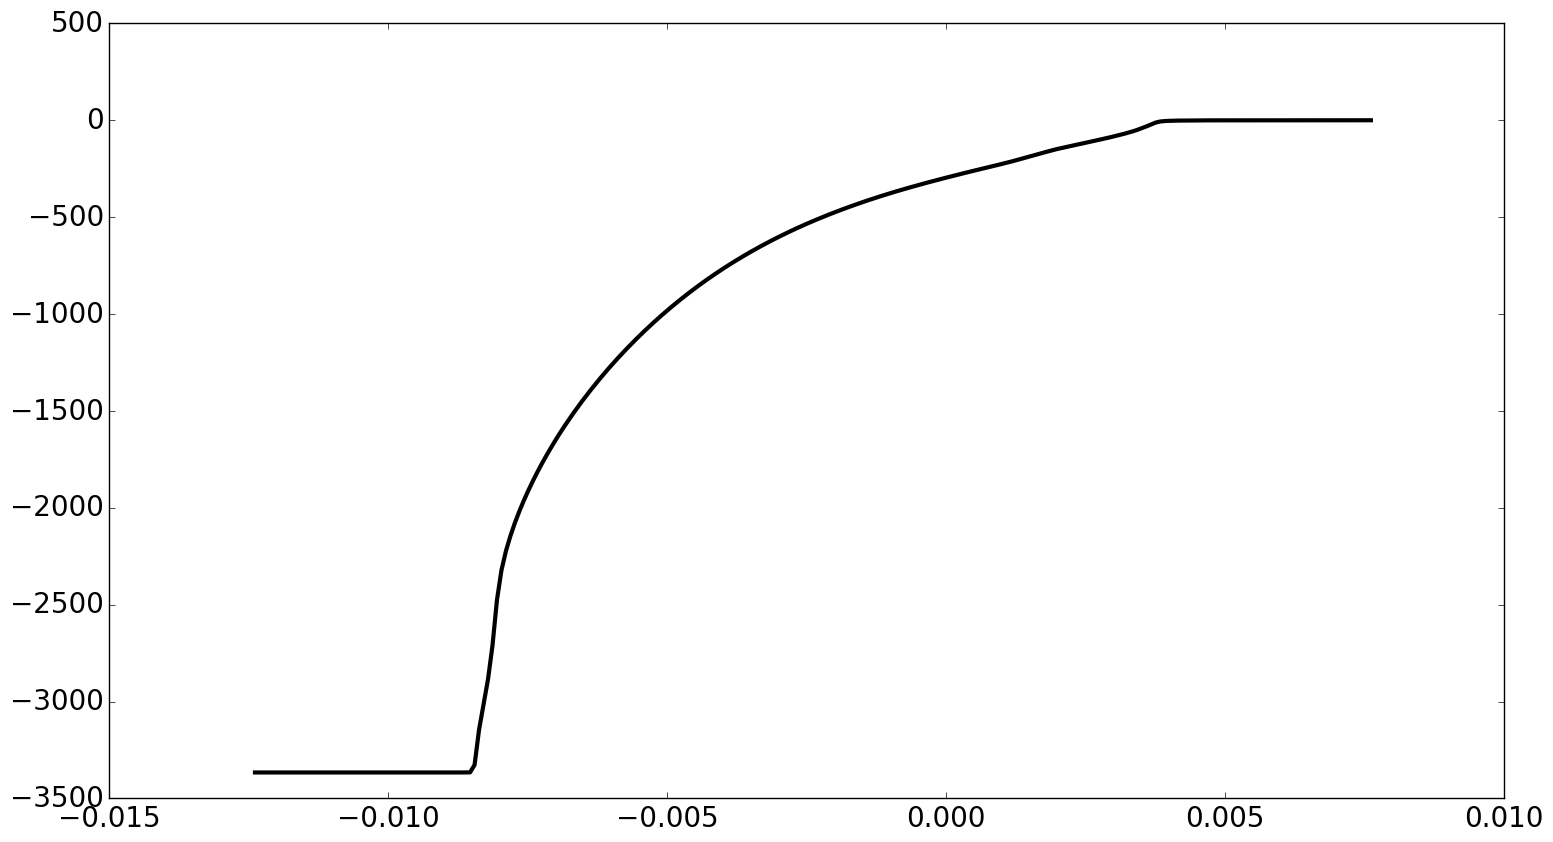

In [332]:
avg_heightMidBuoyCoorEA = zeros_like(binnedheightMidBuoyCoorEA)
avg_heightMidBuoyCoorEA = binnedheightMidBuoyCoorEA[minIndex:maxIndex+1,:]
sumData = avg_heightMidBuoyCoorEA.mean(axis=0)
avg_heightMidBuoyCoorEA = sumData

plt.plot(buoyancy, avg_heightMidBuoyCoorEA, 'k', linewidth=3)

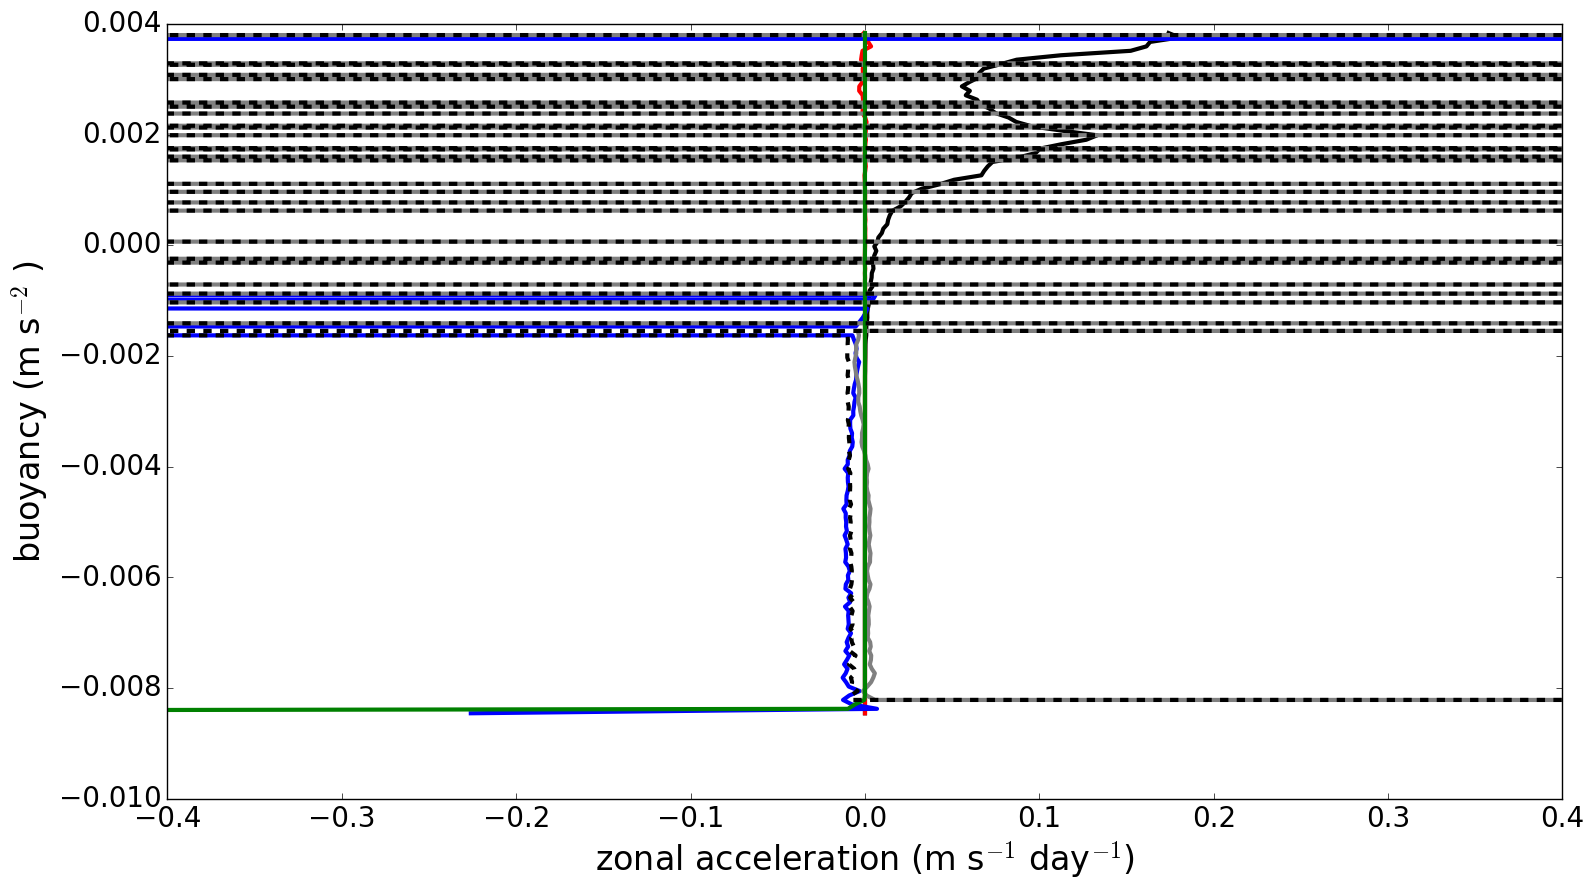

In [333]:
pThreshold = 0.04
plottingNaN = np.NaN

#avg buoyancy mask in x and y
avg_windStress = zeros_like(windStressZonalLayer)
avg_windStress = windStressZonalLayer[minIndex:maxIndex+1,:]
sumData = avg_windStress.mean(axis=0)
avg_windStress = sumData
avg_windStress = np.where(avg_buoyancyMaskEA>pThreshold, avg_windStress, plottingNaN )

avg_verticalAdvection = np.zeros_like(verticalAdvection)
avg_verticalAdvection = verticalAdvection[minIndex:maxIndex+1,:]
sumData = avg_verticalAdvection.mean(axis=0)
avg_verticalAdvection = sumData
avg_verticalAdvection = np.where(avg_buoyancyMaskEA>pThreshold, avg_verticalAdvection, plottingNaN )

avg_coriolisForce = np.zeros_like(coriolisForce)
avg_coriolisForce = coriolisForce[minIndex:maxIndex+1,:]
sumData = avg_coriolisForce.mean(axis=0)
avg_coriolisForce = sumData
avg_coriolisForce = np.where(avg_buoyancyMaskEA>pThreshold, avg_coriolisForce, plottingNaN )

avg_eddyForcingVert = zeros_like(eddyForcingVert)
avg_eddyForcingVert = eddyForcingVert[minIndex:maxIndex+1,:]
sumData = avg_eddyForcingVert.mean(axis=0)
avg_eddyForcingVert = sumData
avg_eddyForcingVert = np.where(avg_buoyancyMaskEA>pThreshold, avg_eddyForcingVert, plottingNaN )

avg_divEPFT = zeros_like(binneddivE)
avg_divEPFT = binneddivE[minIndex:maxIndex+1,:]
sumData = avg_divEPFT.mean(axis=0)
avg_divEPFT = sumData
avg_divEPFT = np.where(avg_buoyancyMaskEA>pThreshold, avg_divEPFT, plottingNaN )

avg_bottomDrag = zeros_like(bottomDrag)
avg_bottomDrag = bottomDrag[minIndex:maxIndex+1,:]
sumData = avg_bottomDrag.mean(axis=0)
avg_bottomDrag = sumData
avg_bottomDrag = np.where(avg_buoyancyMaskEA>pThreshold, avg_bottomDrag, plottingNaN )

avg_residual = avg_windStress + avg_coriolisForce - avg_divEPFT + avg_verticalAdvection - avg_bottomDrag

bPosition = buoyancy

plt.plot(86400.0*avg_windStress, bPosition, color='black', linewidth=3)
plt.plot(86400.0*avg_verticalAdvection, bPosition, color='red', linewidth=3)
plt.plot(86400.0*avg_coriolisForce, bPosition, color='blue', linewidth=3)
plt.plot(-86400.0*avg_divEPFT, bPosition, color='gray',linewidth=3)
plt.plot(-86400.0*avg_bottomDrag, bPosition, color='green',linewidth=3)
plt.plot(86400.0*avg_residual, bPosition, color='black',linewidth=3, linestyle='dashed')
plt.xlim(-0.4, 0.4)
plt.ylim(-0.01, 0.004)
plt.ylabel('buoyancy (m s$^{-2}$ )', **axis_font)
plt.xlabel('zonal acceleration (m s$^{-1}$ day$^{-1}$)', **axis_font)

In [257]:
4096/36.

113.77777777777777

In [ ]:
114*36